In [1]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Introduction

In [2]:
DATA = Path('../input/anadolu-hayat-emeklilik-datathon-coderspace')

df_train = pd.read_csv(DATA / 'train.csv')
df_test = pd.read_csv(DATA / 'test.csv', low_memory=False)

print(f'Training Set Shape: {df_train.shape} - Memory Usage: {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Test Set Shape: {df_test.shape} - Memory Usage: {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Set Shape: (634112, 49) - Memory Usage: 237.06 MB
Test Set Shape: (243137, 48) - Memory Usage: 89.04 MB


## 2. Preprocessing

In [3]:
df_train.loc[df_train['SOZLESME_KOKENI'] == 'TRANS', 'SOZLESME_KOKENI'] = 'TRANS_C'
# Replace comma with dots for float conversion
df_train['GELIR'] = df_train['GELIR'].str.replace(',', '.').astype(np.float32)
df_test['GELIR'] = df_test['GELIR'].str.replace(',', '.').astype(np.float32)
# Few negative values in GELIR are replaced with zero
df_train.loc[df_train['GELIR'] < 0, 'GELIR'] = 0
df_test.loc[df_test['GELIR'] < 0, 'GELIR'] = 0

positive_continous_features = [
    'GELIR',
    'OCAK_ODENEN_TUTAR', 'OCAK_VADE_TUTARI', 'SUBAT_ODENEN_TU', 'SUBAT_VADE_TUTARI',
    'MART_ODENEN_TUTAR', 'MART_VADE_TUTARI', 'NISAN_ODENEN_TUTAR', 'NISAN_VADE_TUTARI',
    'MAYIS_ODENEN_TUTAR', 'MAYIS_VADE_TUTARI', 'HAZIRAN_ODENEN_TUTAR', 'HAZIRAN_VADE_TUTARI',
    'TEMMUZ_ODENEN_TUTAR', 'TEMMUZ_VADE_TUTARI', 'AGUSTOS_ODENEN_TUTAR', 'AGUSTOS_VADE_TUTARI',
    'EYLUL_ODENEN_TUTAR', 'EYLUL_VADE_TUTARI', 'EKIM_ODENEN_TUTAR', 'EKIM_VADE_TUTARI',
    'KASIM_ODENEN_TUTAR', 'KASIM_VADE_TUTARI', 'ARALIK_ODENEN_TUTAR', 'ARALIK_VADE_TUTARI'
]
# Log transform positive continuous features in order to deal with extreme skewness
# Using log1p operation since vanilla log transforms zeros to -infinite
for df in [df_train, df_test]:
    for continous_feature in positive_continous_features:
        df[continous_feature] = np.log1p(df[continous_feature])

positive_and_negative_continuous_features = ['SENE_BASI_HESAP_DEGERI', 'SENE_SONU_HESAP_DEGERI']
# Continuous features with both positive and negative values are standardized
# This makes the continuous features on different scales but that doesn't affect tree-based models
for df in [df_train, df_test]:
    for continous_feature in positive_and_negative_continuous_features:
        smallest_negative_value = pd.concat((
            df_train[continous_feature],
            df_test[continous_feature]
        ), axis=0, ignore_index=True).min()
        df[continous_feature] = np.log1p(df[continous_feature] + 1 - smallest_negative_value)

## 3. Target

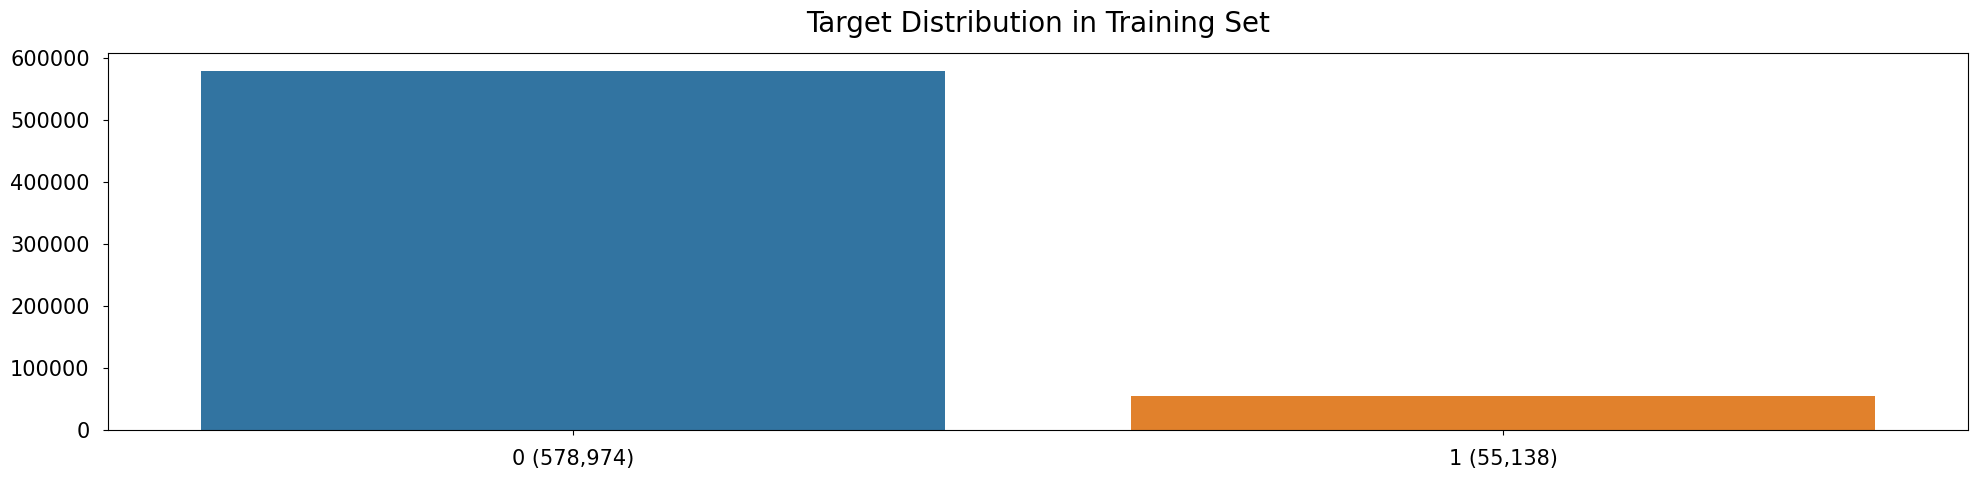

In [4]:
def visualize_target(df_train):
    
    fig, ax = plt.subplots(figsize=(24, 5), dpi=100)

    sns.barplot(
        x=df_train['ARTIS_DURUMU'].value_counts().index,
        y=df_train['ARTIS_DURUMU'].value_counts().values,
        ax=ax
    )

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([f'{x} ({value_count:,})' for value_count, x in zip(df_train['ARTIS_DURUMU'].value_counts().values, df_train['ARTIS_DURUMU'].value_counts().index)])
    ax.tick_params(axis='x', labelsize=15, pad=10)
    ax.tick_params(axis='y', labelsize=15, pad=10)
    ax.set_title('Target Distribution in Training Set', size=20, pad=15)

    plt.show()


visualize_target(df_train)

## 4. Continuous Features

GELIR
-----

Training
--------
Mean: 6.0693  -  Median: 7.6014  -  Std: 3.3057
Min: 0.0000  -  25%: 6.2166  -  50%: 7.6014  -  75%: 8.0067  -  Max: 32.9293
Skew: -1.1366  -  Kurtosis: -0.3911
Missing Values: 77644/634112 (12.2445%)

Test
----
Mean: 6.1161  -  Median: 7.6014  -  Std: 3.2682
Min: 0.0000  -  25%: 6.2166  -  50%: 7.6014  -  75%: 8.0067  -  Max: 23.0259
Skew: -1.1754  -  Kurtosis: -0.3013
Missing Values: 29721/243137 (12.2240%)


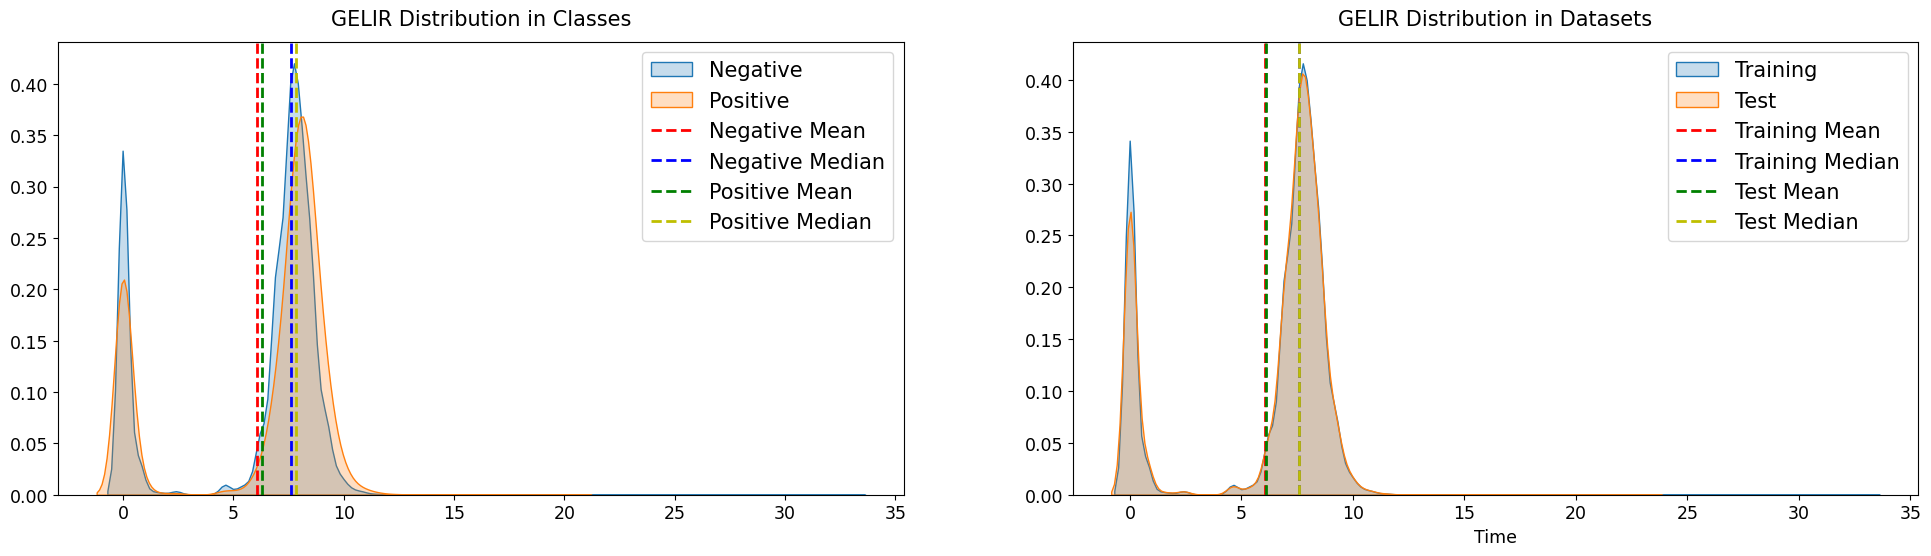

OCAK_ODENEN_TUTAR
-----------------

Training
--------
Mean: 3.2735  -  Median: 5.0814  -  Std: 2.8041
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0814  -  75%: 5.6021  -  Max: 9.9035
Skew: -0.2469  -  Kurtosis: -1.7955
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 3.2529  -  Median: 5.0814  -  Std: 2.7995
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0814  -  75%: 5.6021  -  Max: 10.3090
Skew: -0.2404  -  Kurtosis: -1.8053
Missing Values: 0/243137 (0.0000%)


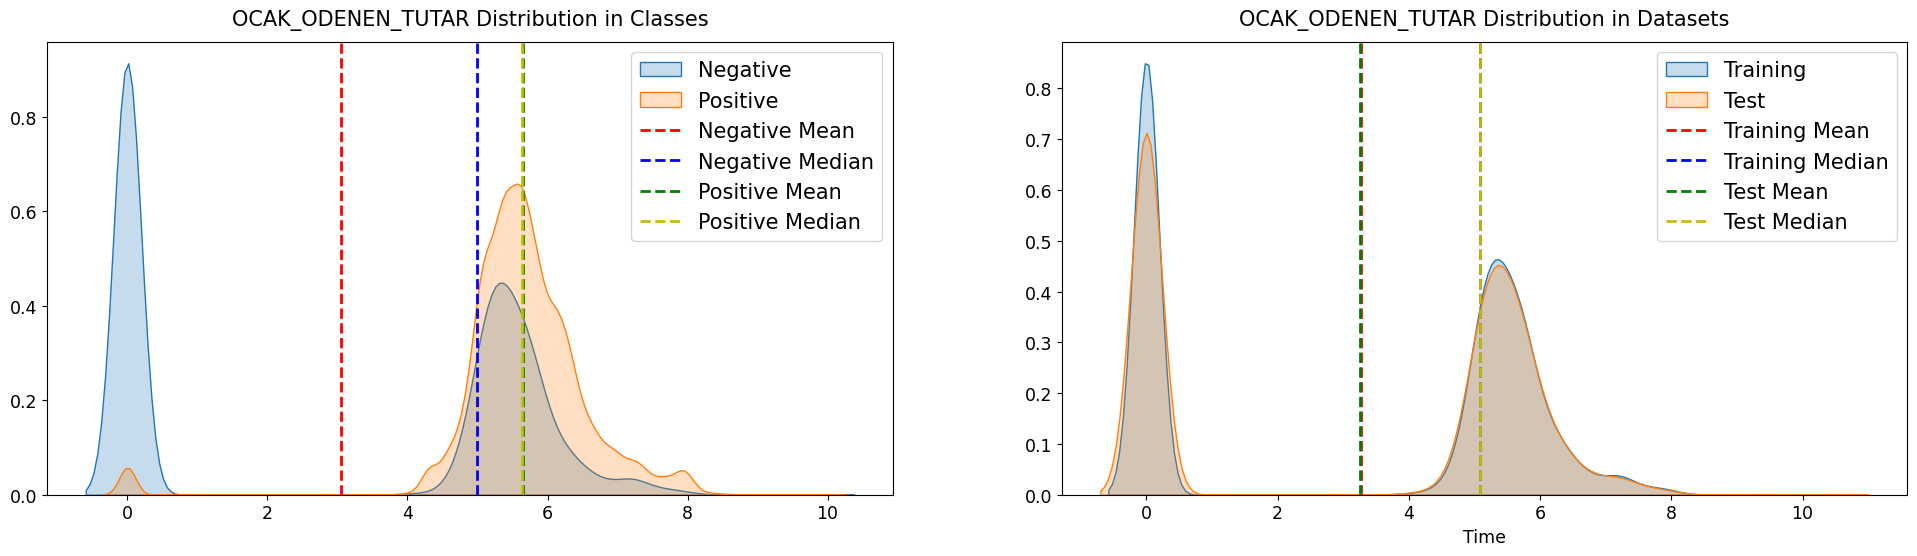

OCAK_VADE_TUTARI
----------------

Training
--------
Mean: 5.5432  -  Median: 5.4337  -  Std: 0.5598
Min: 2.8904  -  25%: 5.1417  -  50%: 5.4337  -  75%: 5.8319  -  Max: 12.6115
Skew: 1.2800  -  Kurtosis: 3.3881
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 5.5433  -  Median: 5.4424  -  Std: 0.5448
Min: 2.9972  -  25%: 5.1985  -  50%: 5.4424  -  75%: 5.8319  -  Max: 12.5975
Skew: 1.2876  -  Kurtosis: 3.5649
Missing Values: 0/243137 (0.0000%)


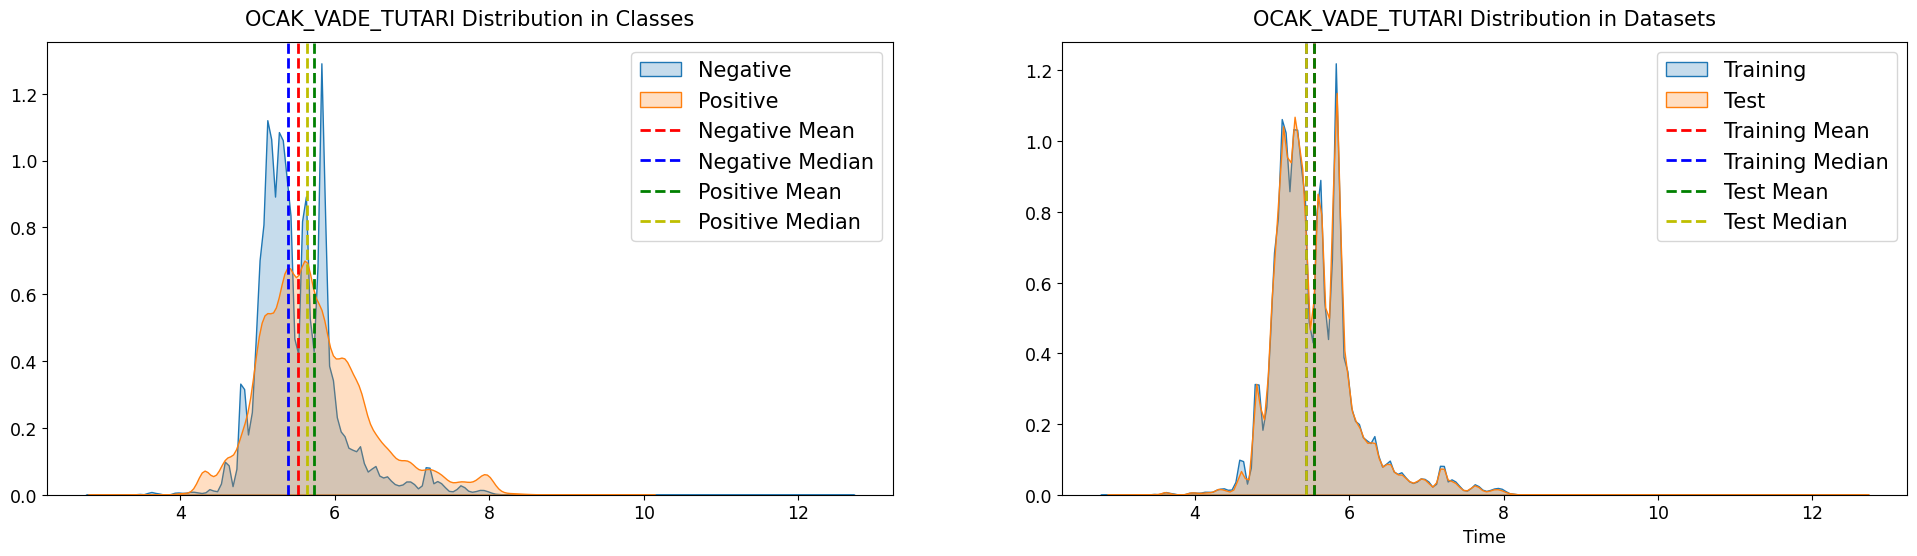

SUBAT_ODENEN_TU
---------------

Training
--------
Mean: 3.2613  -  Median: 5.0814  -  Std: 2.8081
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0814  -  75%: 5.6021  -  Max: 9.9035
Skew: -0.2367  -  Kurtosis: -1.8010
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 3.2403  -  Median: 5.0370  -  Std: 2.8032
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0370  -  75%: 5.6021  -  Max: 10.3090
Skew: -0.2300  -  Kurtosis: -1.8107
Missing Values: 0/243137 (0.0000%)


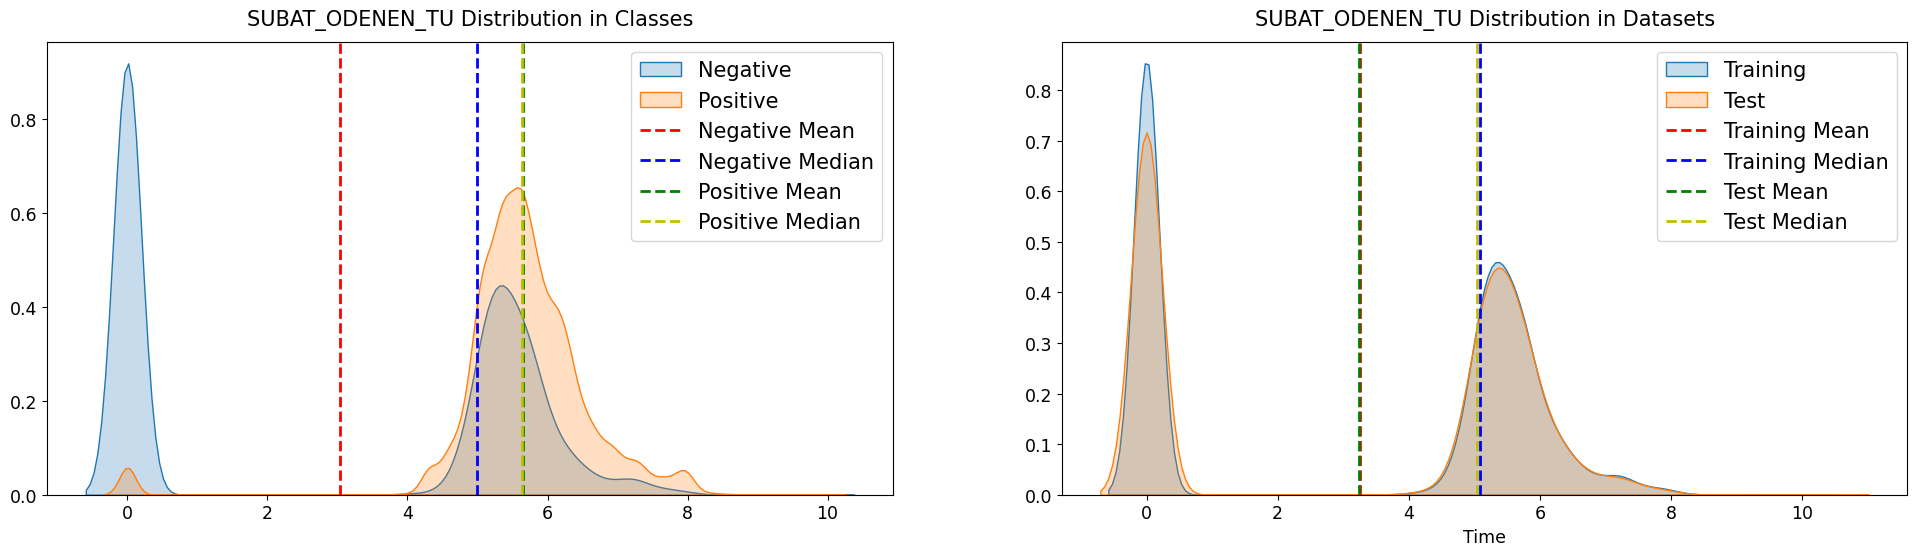

SUBAT_VADE_TUTARI
-----------------

Training
--------
Mean: 5.5446  -  Median: 5.4337  -  Std: 0.5608
Min: 2.8904  -  25%: 5.1417  -  50%: 5.4337  -  75%: 5.8319  -  Max: 11.4273
Skew: 1.2776  -  Kurtosis: 3.3404
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 5.5445  -  Median: 5.4424  -  Std: 0.5457
Min: 2.9972  -  25%: 5.1985  -  50%: 5.4424  -  75%: 5.8319  -  Max: 12.5975
Skew: 1.2894  -  Kurtosis: 3.5658
Missing Values: 0/243137 (0.0000%)


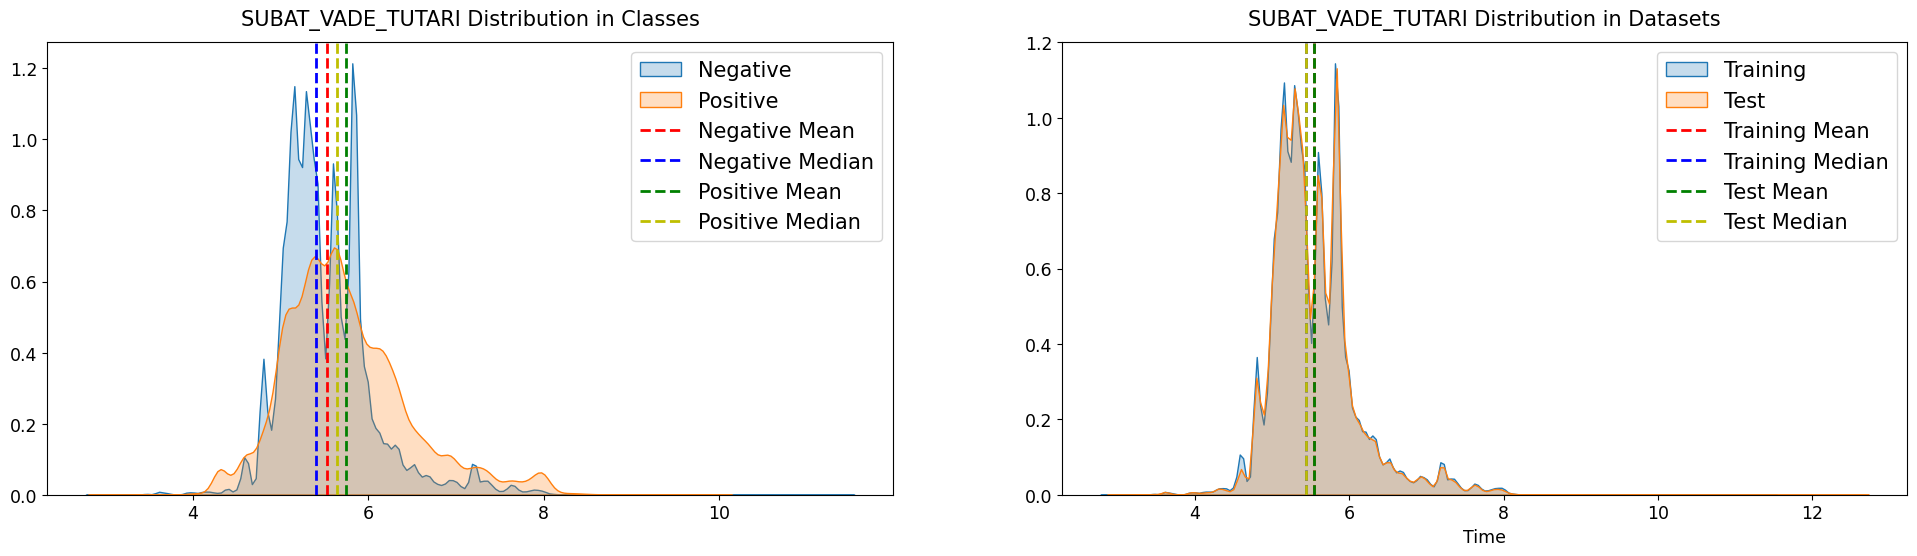

MART_ODENEN_TUTAR
-----------------

Training
--------
Mean: 3.2522  -  Median: 5.0814  -  Std: 2.8106
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0814  -  75%: 5.6021  -  Max: 9.9035
Skew: -0.2295  -  Kurtosis: -1.8051
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 3.2314  -  Median: 5.0173  -  Std: 2.8055
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0173  -  75%: 5.6021  -  Max: 10.3090
Skew: -0.2232  -  Kurtosis: -1.8145
Missing Values: 0/243137 (0.0000%)


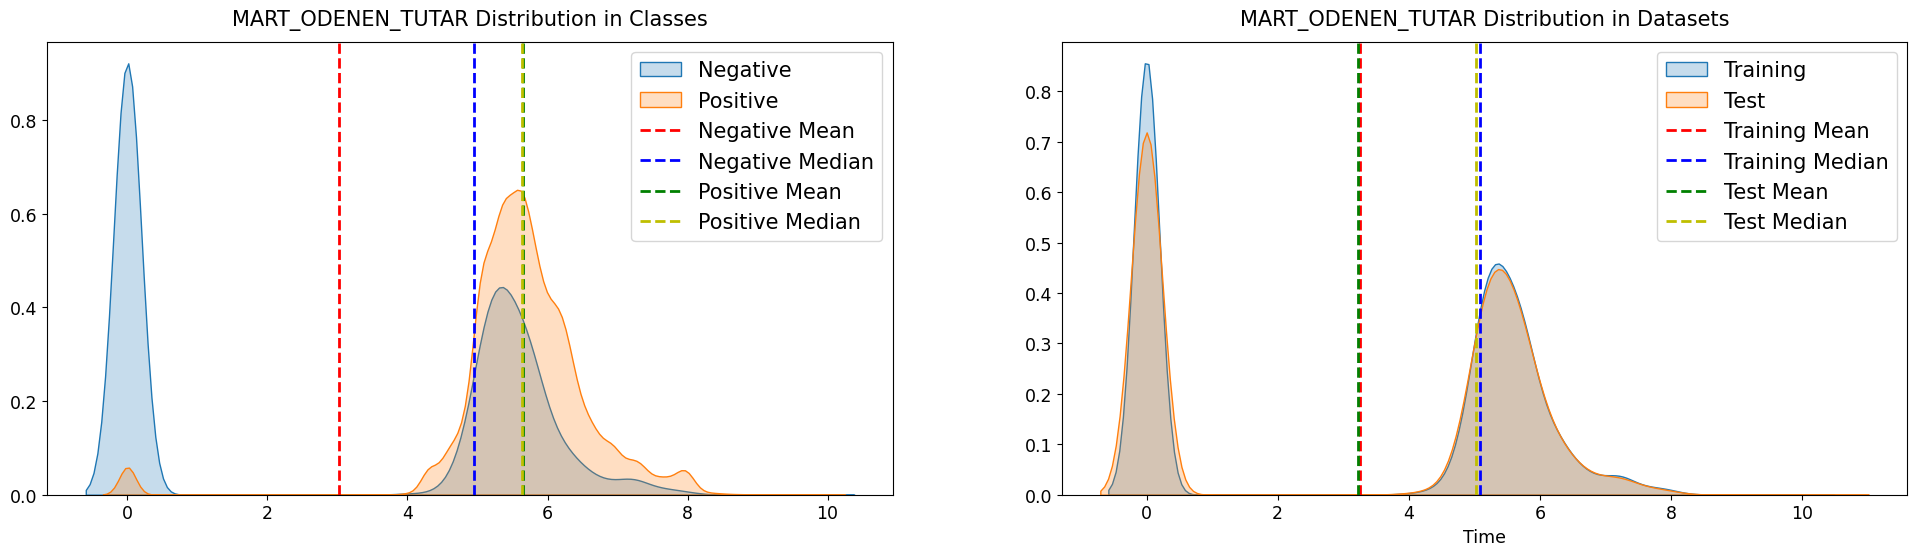

MART_VADE_TUTARI
----------------

Training
--------
Mean: 5.5455  -  Median: 5.4337  -  Std: 0.5610
Min: 2.8904  -  25%: 5.1417  -  50%: 5.4337  -  75%: 5.8319  -  Max: 11.4273
Skew: 1.2780  -  Kurtosis: 3.3437
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 5.5454  -  Median: 5.4424  -  Std: 0.5460
Min: 2.9972  -  25%: 5.1985  -  50%: 5.4424  -  75%: 5.8319  -  Max: 12.5975
Skew: 1.2907  -  Kurtosis: 3.5754
Missing Values: 0/243137 (0.0000%)


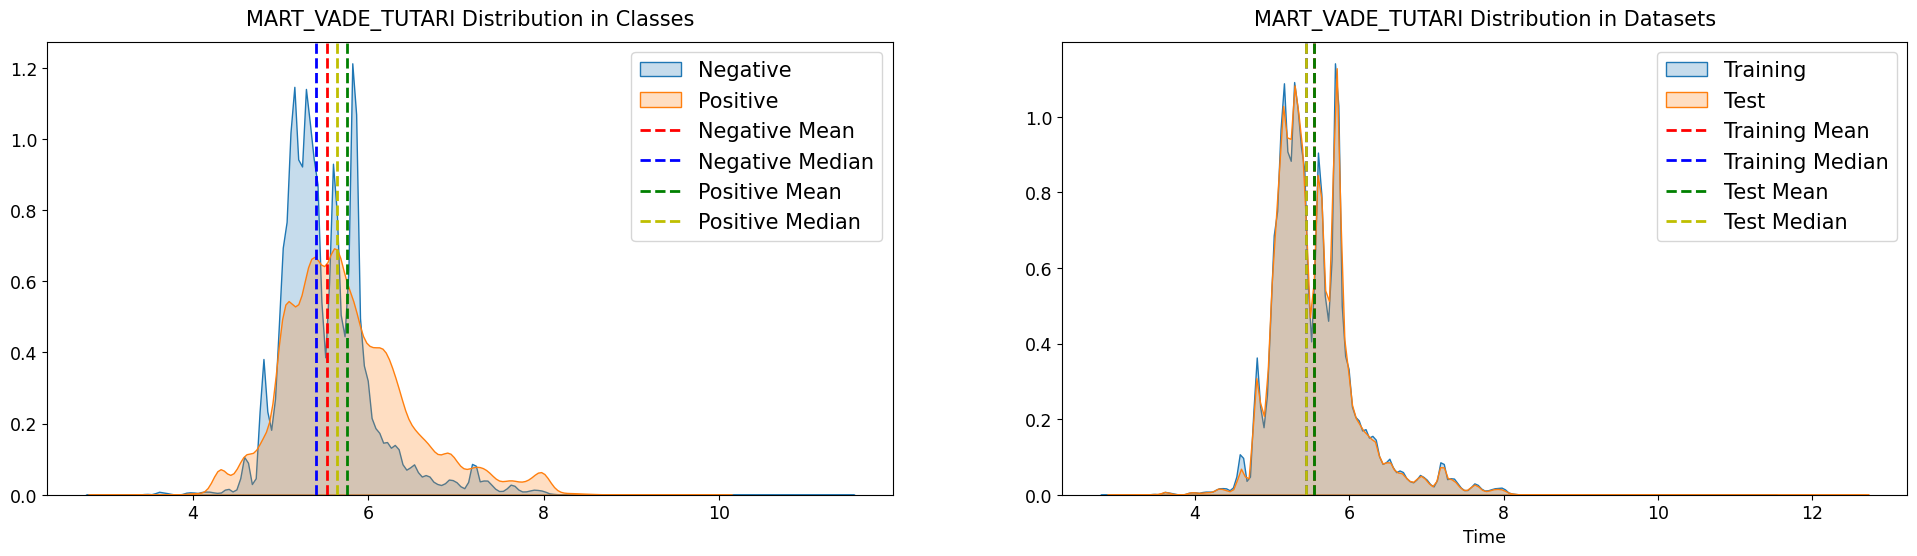

NISAN_ODENEN_TUTAR
------------------

Training
--------
Mean: 3.2443  -  Median: 5.0239  -  Std: 2.8119
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0239  -  75%: 5.6021  -  Max: 9.9035
Skew: -0.2241  -  Kurtosis: -1.8085
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 3.2219  -  Median: 5.0173  -  Std: 2.8072
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0173  -  75%: 5.6021  -  Max: 10.3090
Skew: -0.2162  -  Kurtosis: -1.8182
Missing Values: 0/243137 (0.0000%)


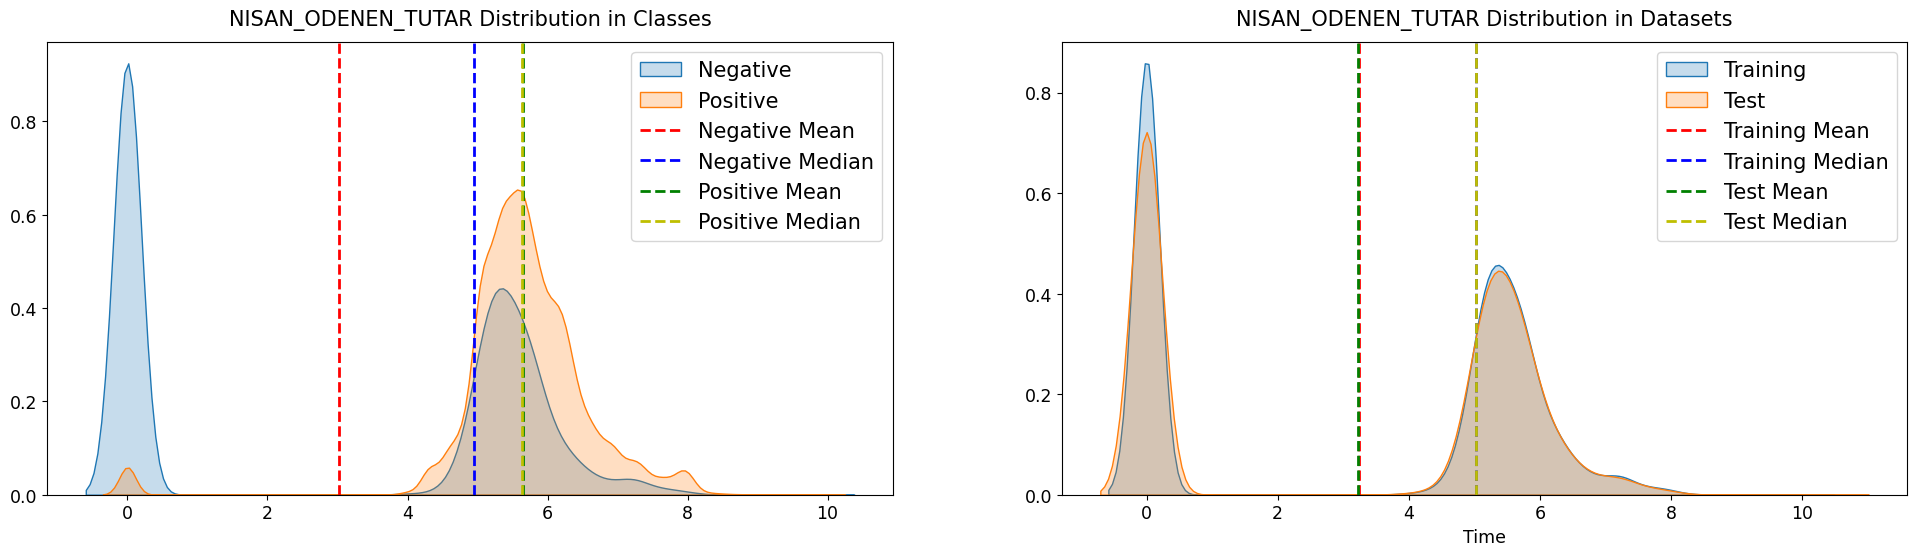

NISAN_VADE_TUTARI
-----------------

Training
--------
Mean: 5.5455  -  Median: 5.4424  -  Std: 0.5608
Min: 2.8904  -  25%: 5.1417  -  50%: 5.4424  -  75%: 5.8319  -  Max: 11.4273
Skew: 1.2728  -  Kurtosis: 3.3392
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 5.5454  -  Median: 5.4424  -  Std: 0.5459
Min: 2.9972  -  25%: 5.1985  -  50%: 5.4424  -  75%: 5.8319  -  Max: 12.5975
Skew: 1.2873  -  Kurtosis: 3.5788
Missing Values: 0/243137 (0.0000%)


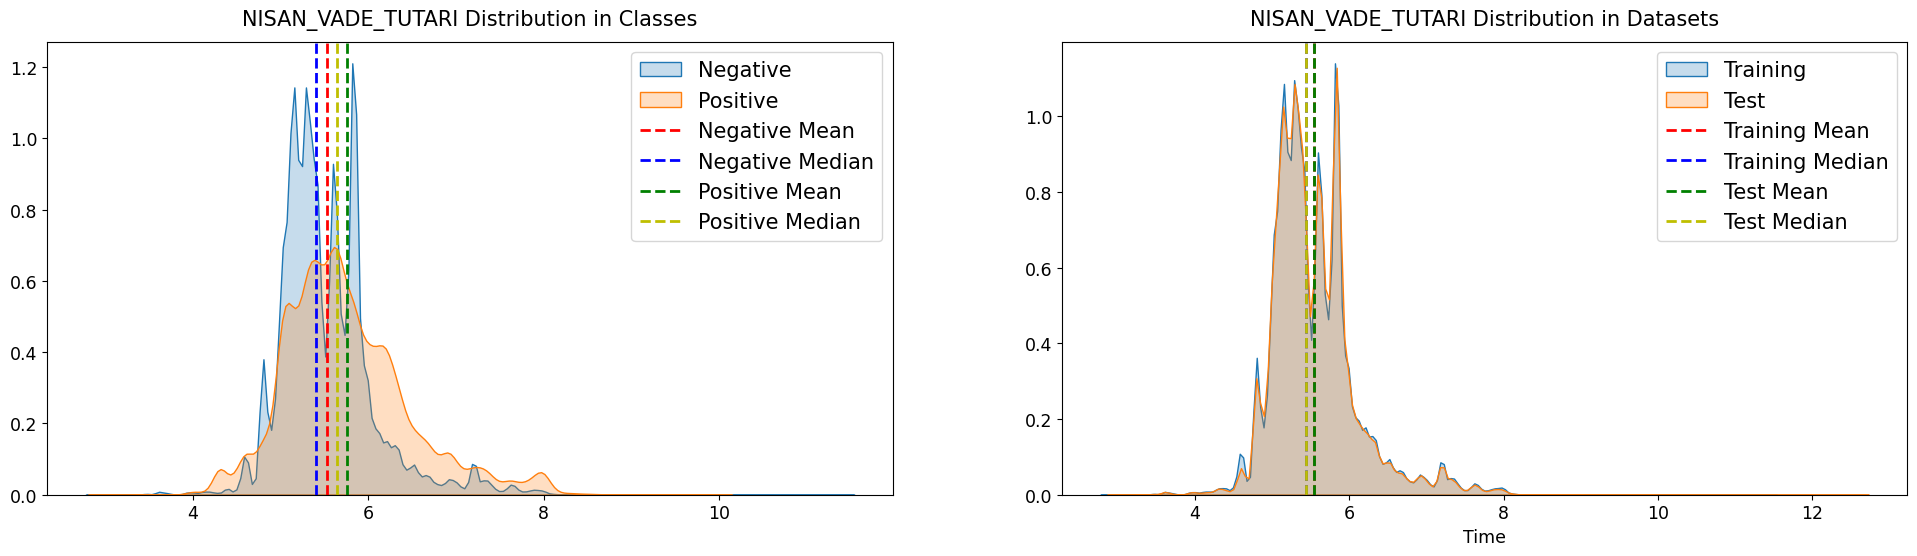

MAYIS_ODENEN_TUTAR
------------------

Training
--------
Mean: 3.2374  -  Median: 5.0173  -  Std: 2.8141
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0173  -  75%: 5.6021  -  Max: 10.1267
Skew: -0.2182  -  Kurtosis: -1.8112
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 3.2152  -  Median: 5.0173  -  Std: 2.8093
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0173  -  75%: 5.6021  -  Max: 10.3090
Skew: -0.2105  -  Kurtosis: -1.8208
Missing Values: 0/243137 (0.0000%)


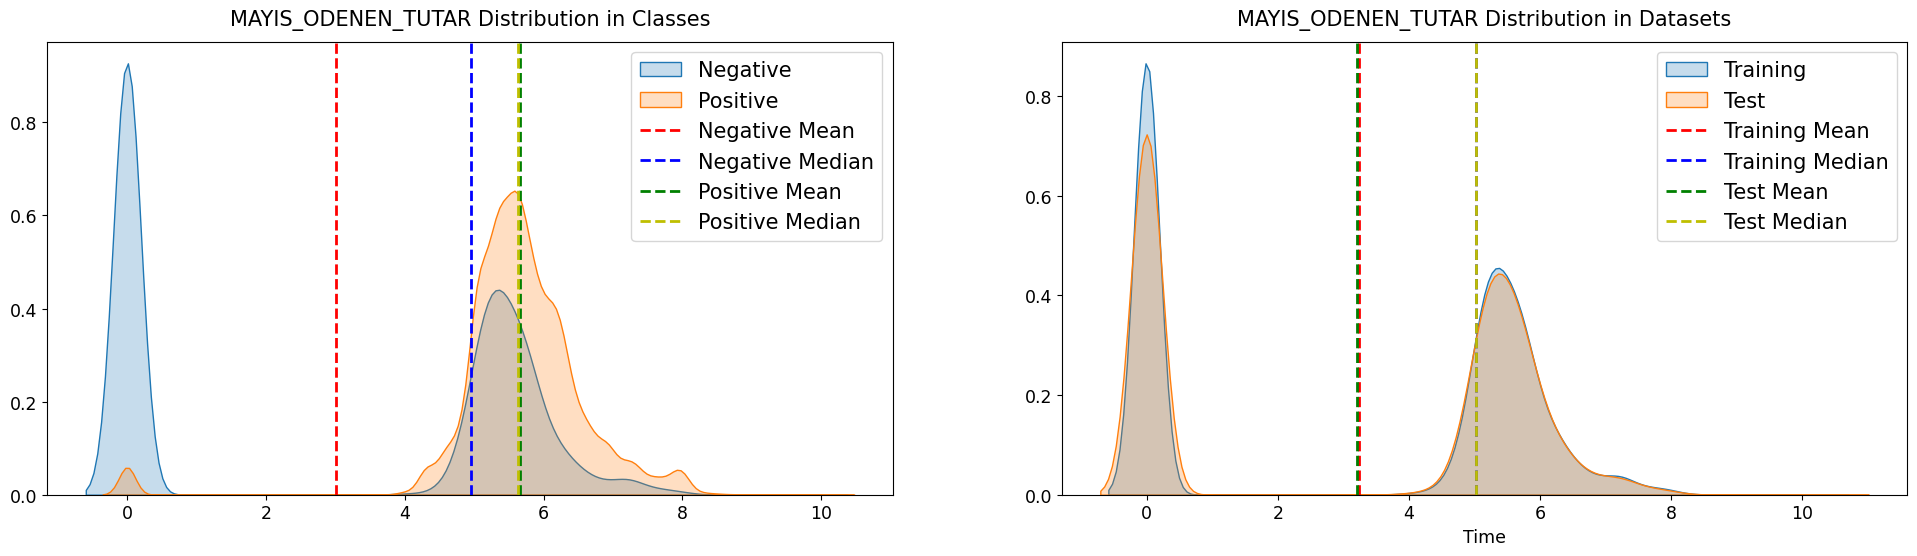

MAYIS_VADE_TUTARI
-----------------

Training
--------
Mean: 5.5466  -  Median: 5.4424  -  Std: 0.5618
Min: 2.8904  -  25%: 5.1417  -  50%: 5.4424  -  75%: 5.8319  -  Max: 12.4292
Skew: 1.2767  -  Kurtosis: 3.3735
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 5.5464  -  Median: 5.4424  -  Std: 0.5467
Min: 2.9972  -  25%: 5.1985  -  50%: 5.4424  -  75%: 5.8319  -  Max: 12.5975
Skew: 1.2877  -  Kurtosis: 3.5684
Missing Values: 0/243137 (0.0000%)


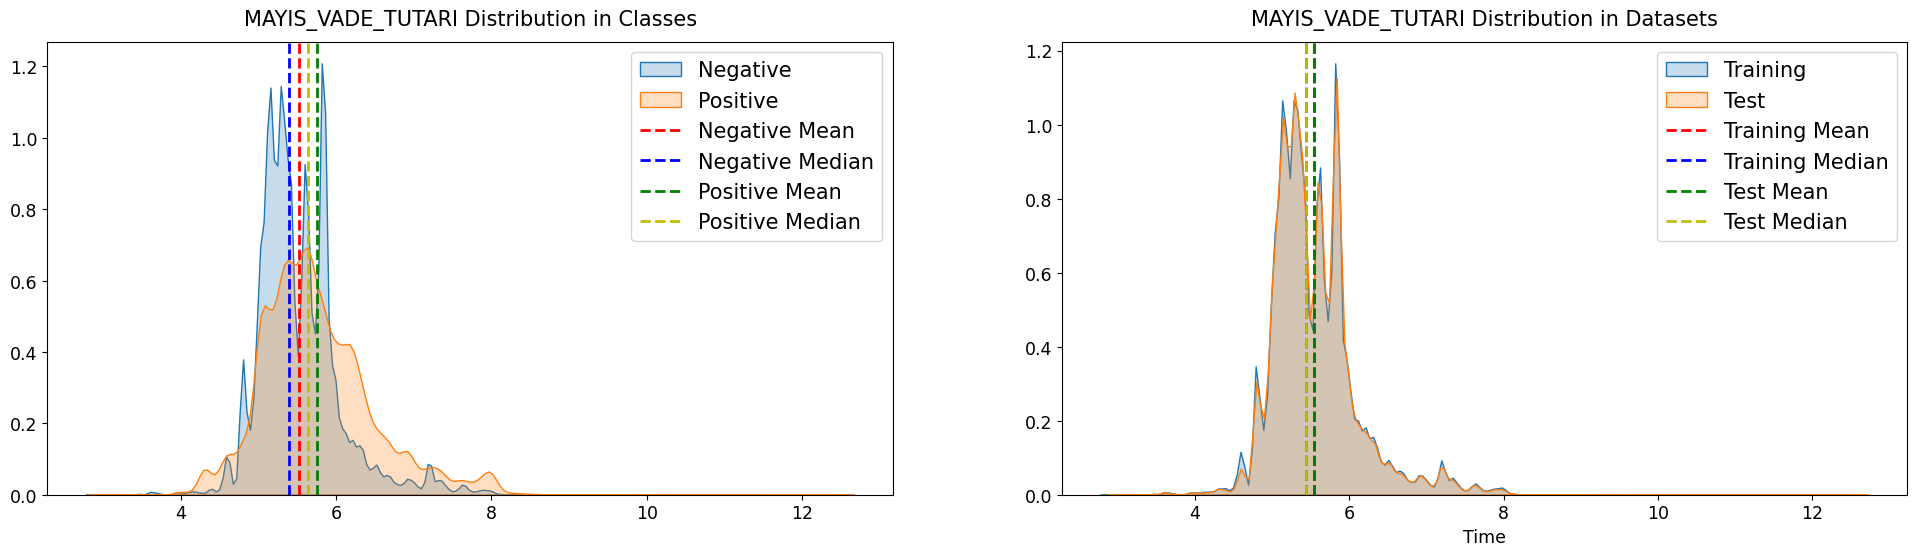

HAZIRAN_ODENEN_TUTAR
--------------------

Training
--------
Mean: 3.2302  -  Median: 5.0173  -  Std: 2.8170
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0173  -  75%: 5.6021  -  Max: 10.2538
Skew: -0.2115  -  Kurtosis: -1.8139
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 3.2096  -  Median: 5.0173  -  Std: 2.8121
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0173  -  75%: 5.6021  -  Max: 10.5967
Skew: -0.2049  -  Kurtosis: -1.8229
Missing Values: 0/243137 (0.0000%)


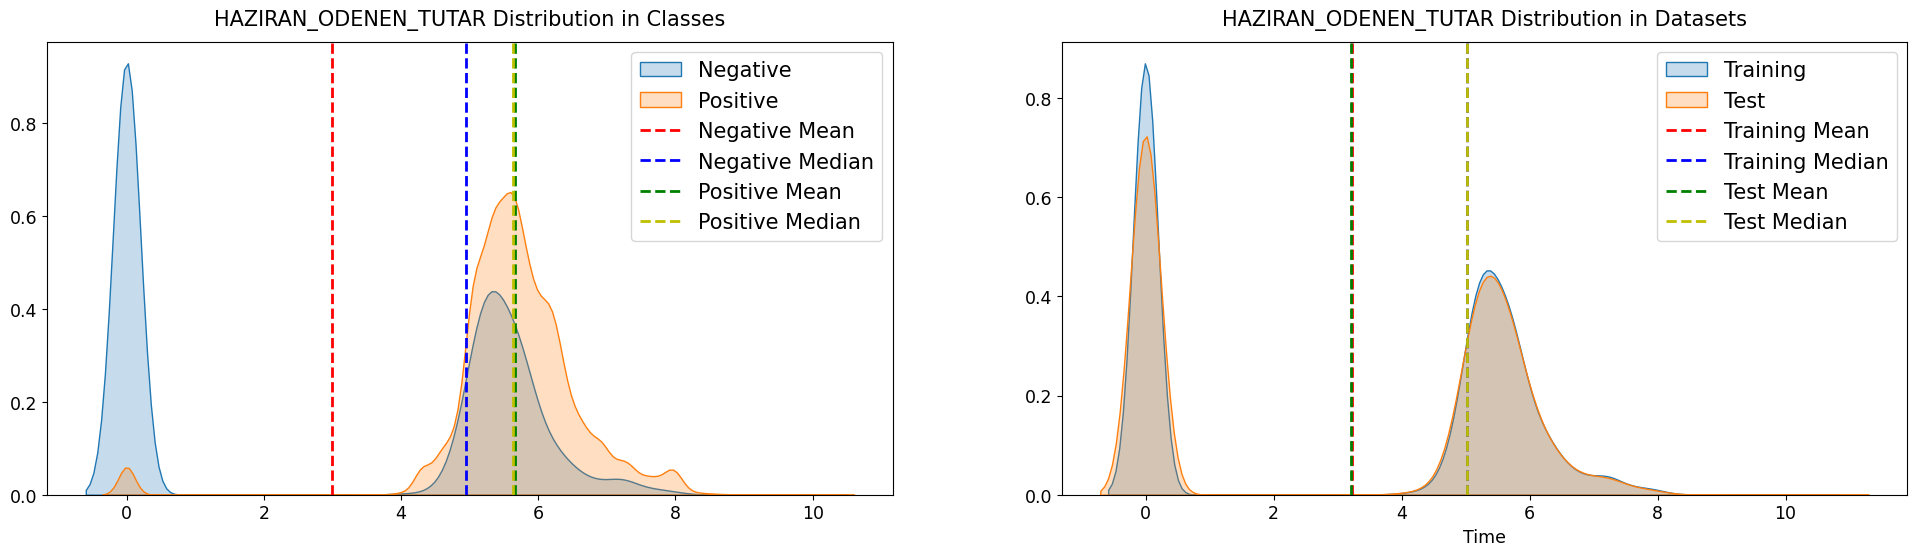

HAZIRAN_VADE_TUTARI
-------------------

Training
--------
Mean: 5.5480  -  Median: 5.4424  -  Std: 0.5631
Min: 2.8904  -  25%: 5.1417  -  50%: 5.4424  -  75%: 5.8319  -  Max: 12.4292
Skew: 1.2792  -  Kurtosis: 3.3756
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 5.5479  -  Median: 5.4424  -  Std: 0.5480
Min: 2.9972  -  25%: 5.1985  -  50%: 5.4424  -  75%: 5.8319  -  Max: 12.5975
Skew: 1.2864  -  Kurtosis: 3.5446
Missing Values: 0/243137 (0.0000%)


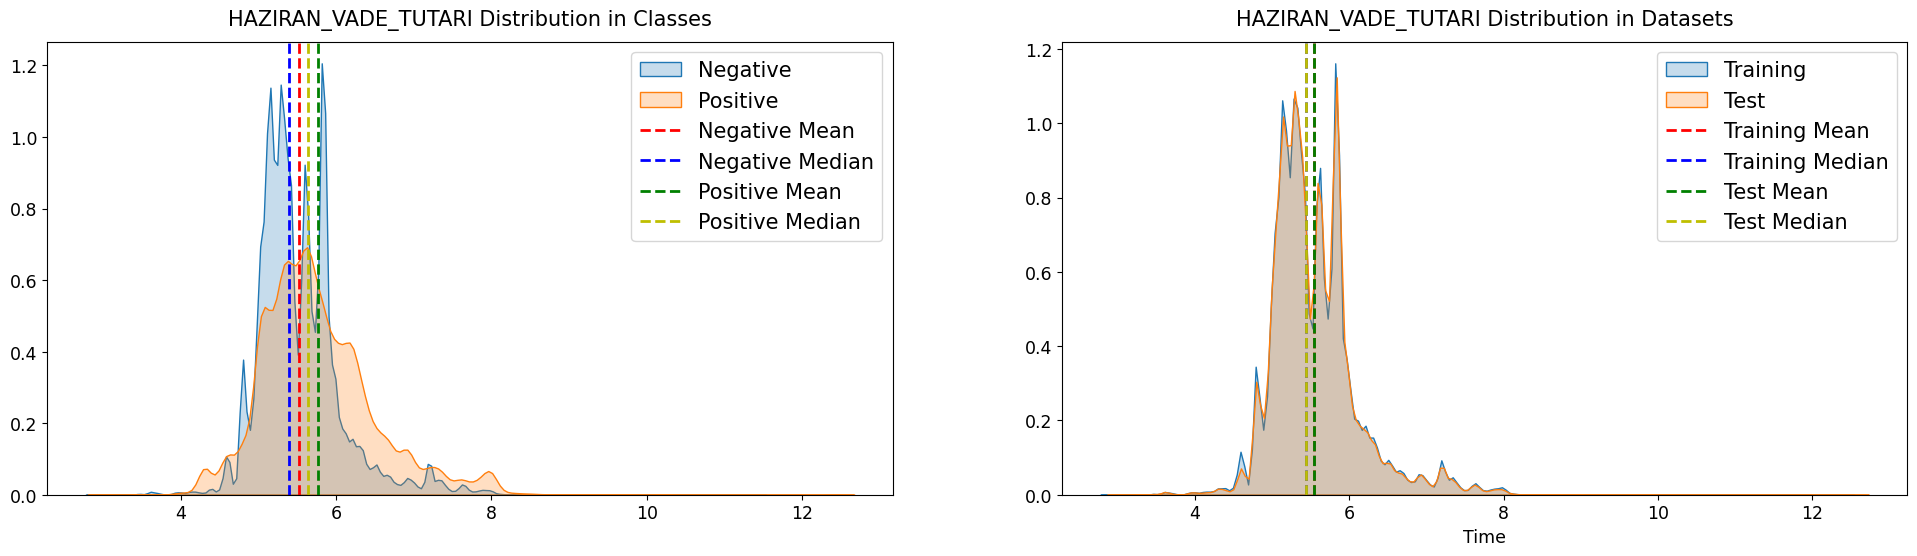

TEMMUZ_ODENEN_TUTAR
-------------------

Training
--------
Mean: 3.2228  -  Median: 5.0173  -  Std: 2.8201
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0173  -  75%: 5.6021  -  Max: 10.1267
Skew: -0.2046  -  Kurtosis: -1.8168
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 3.2034  -  Median: 5.0173  -  Std: 2.8151
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0173  -  75%: 5.6021  -  Max: 10.5967
Skew: -0.1988  -  Kurtosis: -1.8254
Missing Values: 0/243137 (0.0000%)


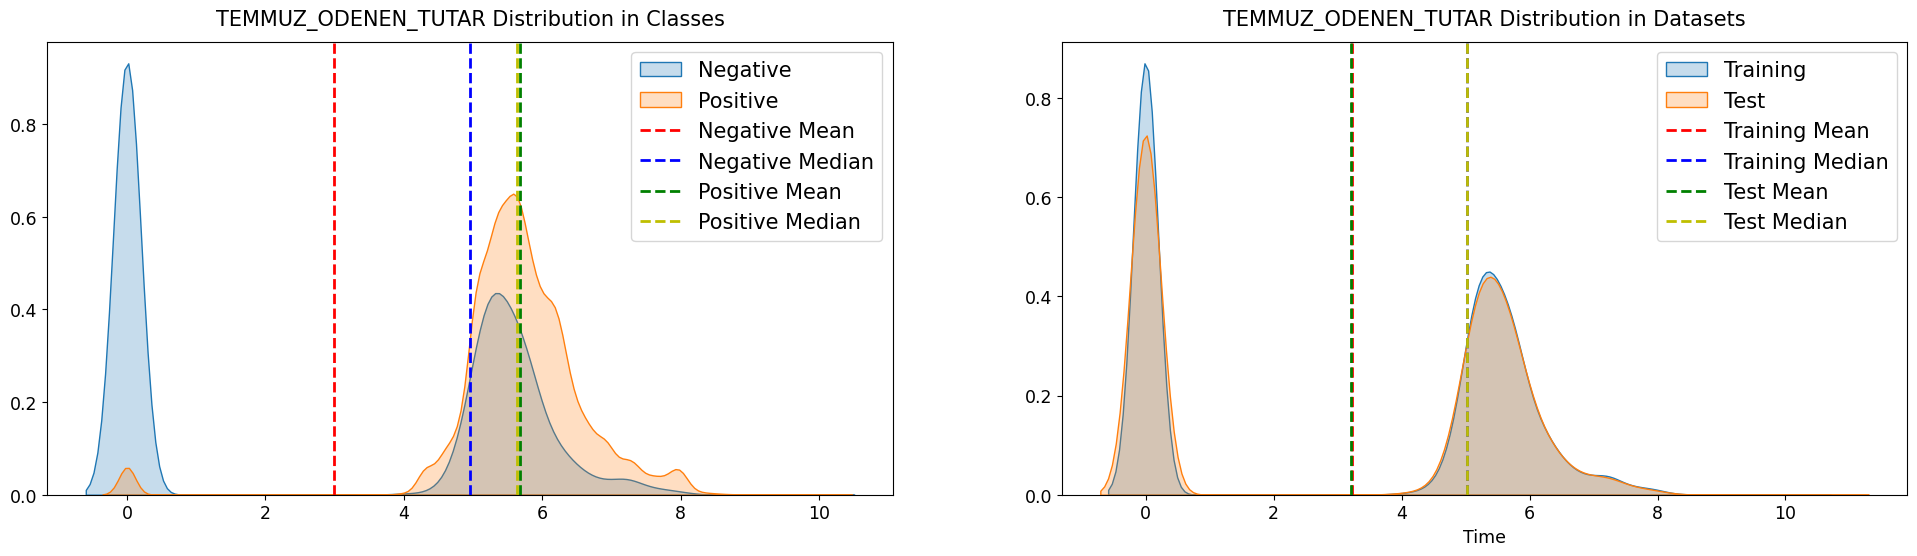

TEMMUZ_VADE_TUTARI
------------------

Training
--------
Mean: 5.5496  -  Median: 5.4424  -  Std: 0.5645
Min: 2.8904  -  25%: 5.1417  -  50%: 5.4424  -  75%: 5.8319  -  Max: 12.6115
Skew: 1.2789  -  Kurtosis: 3.3377
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 5.5497  -  Median: 5.4424  -  Std: 0.5494
Min: 2.9972  -  25%: 5.1985  -  50%: 5.4424  -  75%: 5.8319  -  Max: 12.5975
Skew: 1.2878  -  Kurtosis: 3.5212
Missing Values: 0/243137 (0.0000%)


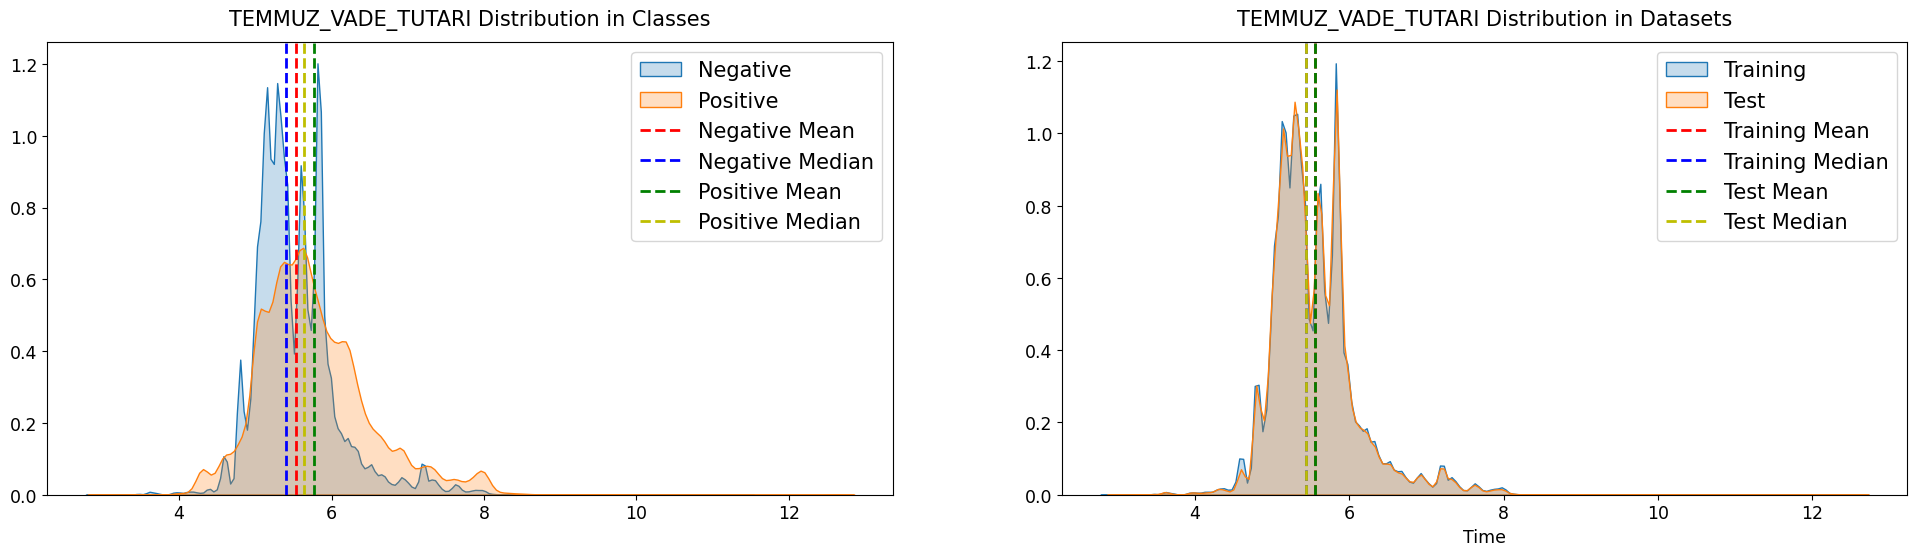

AGUSTOS_ODENEN_TUTAR
--------------------

Training
--------
Mean: 3.2155  -  Median: 5.0173  -  Std: 2.8235
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0173  -  75%: 5.6021  -  Max: 10.1267
Skew: -0.1976  -  Kurtosis: -1.8198
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 3.1951  -  Median: 5.0173  -  Std: 2.8184
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0173  -  75%: 5.6021  -  Max: 10.5967
Skew: -0.1913  -  Kurtosis: -1.8286
Missing Values: 0/243137 (0.0000%)


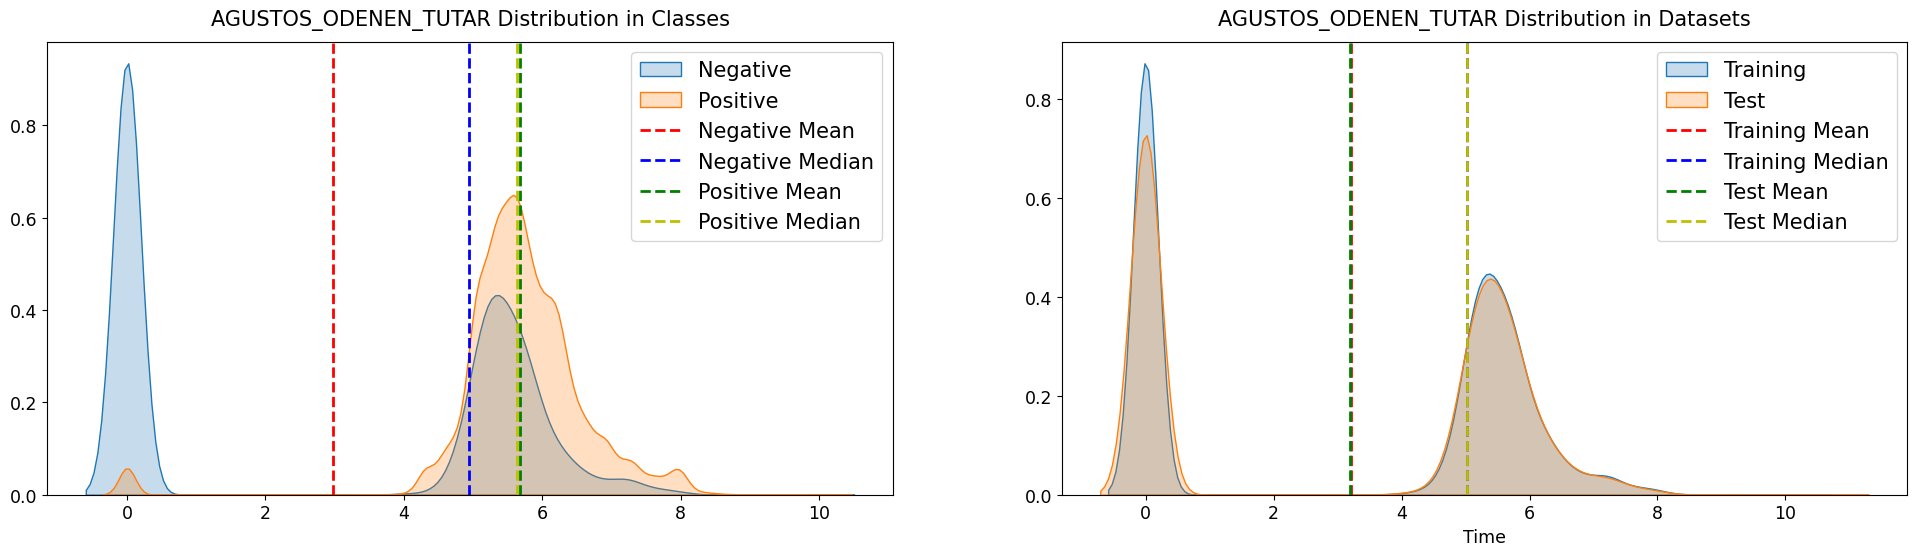

AGUSTOS_VADE_TUTARI
-------------------

Training
--------
Mean: 5.5516  -  Median: 5.4424  -  Std: 0.5657
Min: 2.8904  -  25%: 5.1417  -  50%: 5.4424  -  75%: 5.8319  -  Max: 12.6115
Skew: 1.2780  -  Kurtosis: 3.3271
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 5.5517  -  Median: 5.4424  -  Std: 0.5509
Min: 2.9972  -  25%: 5.1985  -  50%: 5.4424  -  75%: 5.8319  -  Max: 12.5975
Skew: 1.2866  -  Kurtosis: 3.5079
Missing Values: 0/243137 (0.0000%)


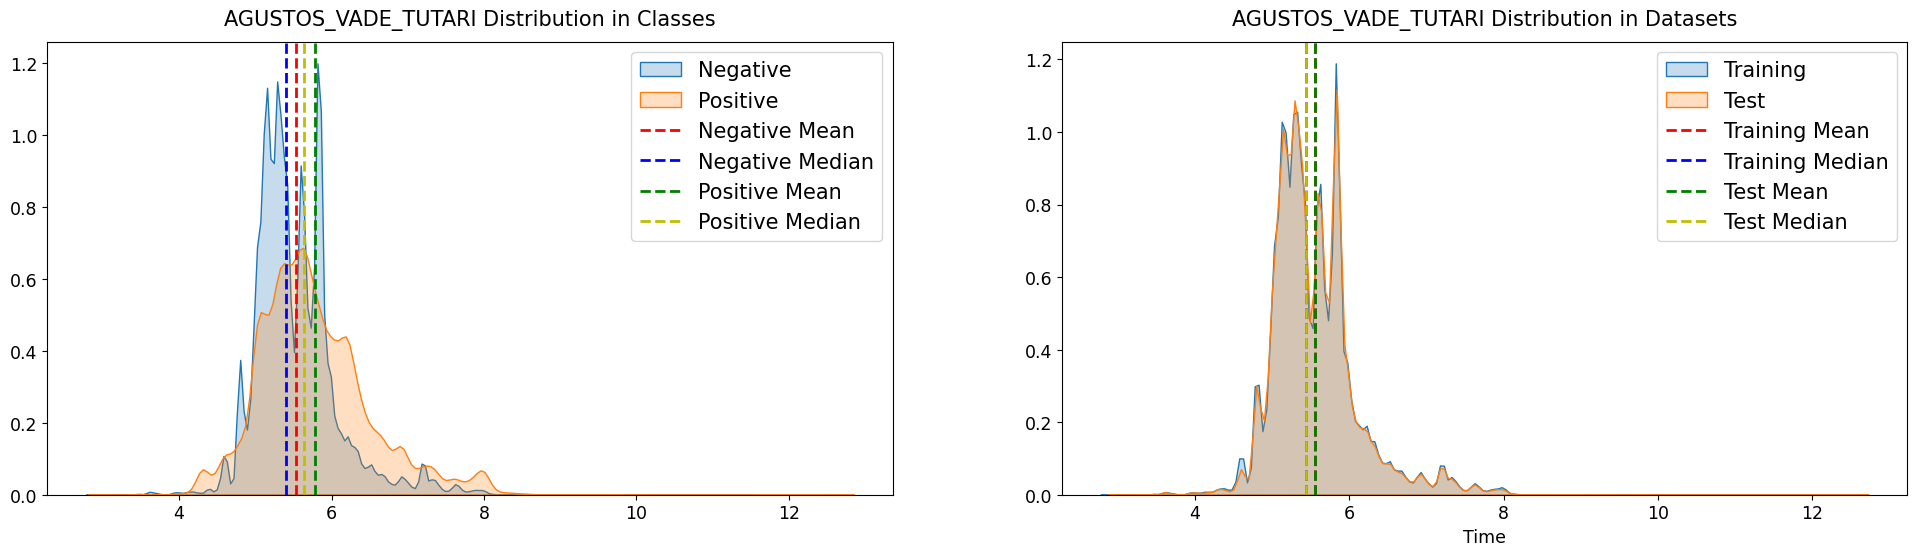

EYLUL_ODENEN_TUTAR
------------------

Training
--------
Mean: 3.2064  -  Median: 5.0173  -  Std: 2.8268
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0173  -  75%: 5.6021  -  Max: 10.1267
Skew: -0.1897  -  Kurtosis: -1.8233
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 3.1863  -  Median: 5.0173  -  Std: 2.8216
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0173  -  75%: 5.6021  -  Max: 10.7144
Skew: -0.1835  -  Kurtosis: -1.8319
Missing Values: 0/243137 (0.0000%)


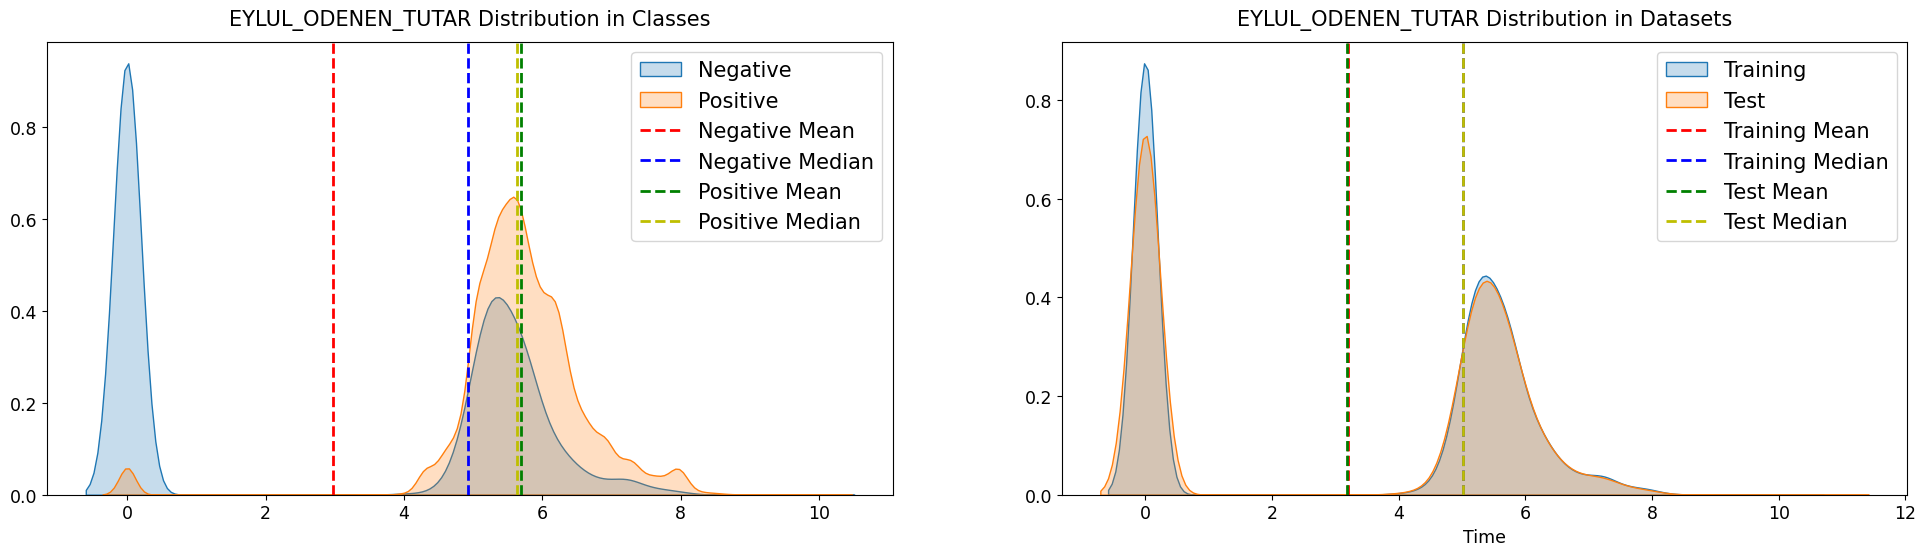

EYLUL_VADE_TUTARI
-----------------

Training
--------
Mean: 5.5534  -  Median: 5.4424  -  Std: 0.5666
Min: 2.8904  -  25%: 5.1728  -  50%: 5.4424  -  75%: 5.8319  -  Max: 12.6115
Skew: 1.2778  -  Kurtosis: 3.3204
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 5.5535  -  Median: 5.4424  -  Std: 0.5520
Min: 2.9972  -  25%: 5.1985  -  50%: 5.4424  -  75%: 5.8319  -  Max: 15.1554
Skew: 1.3045  -  Kurtosis: 3.8554
Missing Values: 0/243137 (0.0000%)


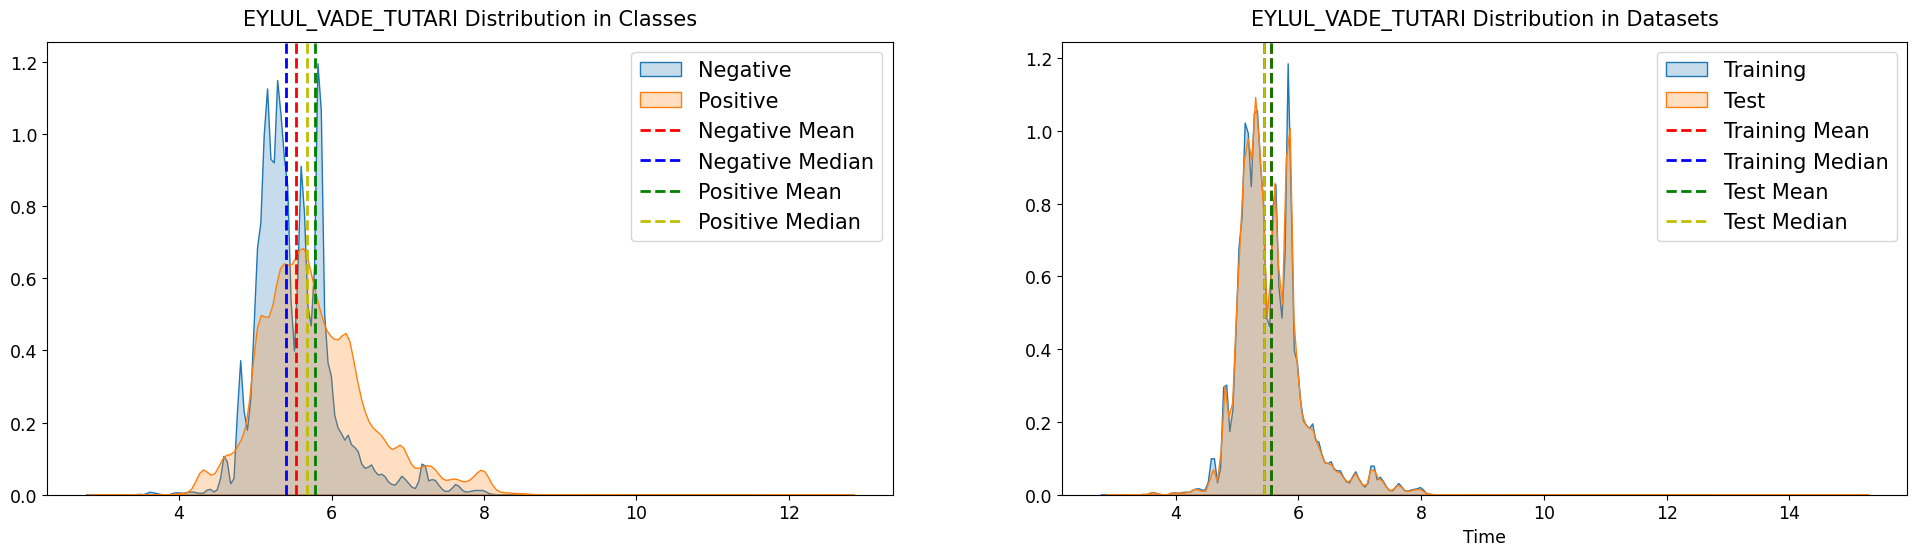

EKIM_ODENEN_TUTAR
-----------------

Training
--------
Mean: 3.2031  -  Median: 5.0173  -  Std: 2.8292
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0173  -  75%: 5.6021  -  Max: 10.1267
Skew: -0.1859  -  Kurtosis: -1.8246
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 3.1809  -  Median: 5.0173  -  Std: 2.8241
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0173  -  75%: 5.6021  -  Max: 10.7144
Skew: -0.1785  -  Kurtosis: -1.8339
Missing Values: 0/243137 (0.0000%)


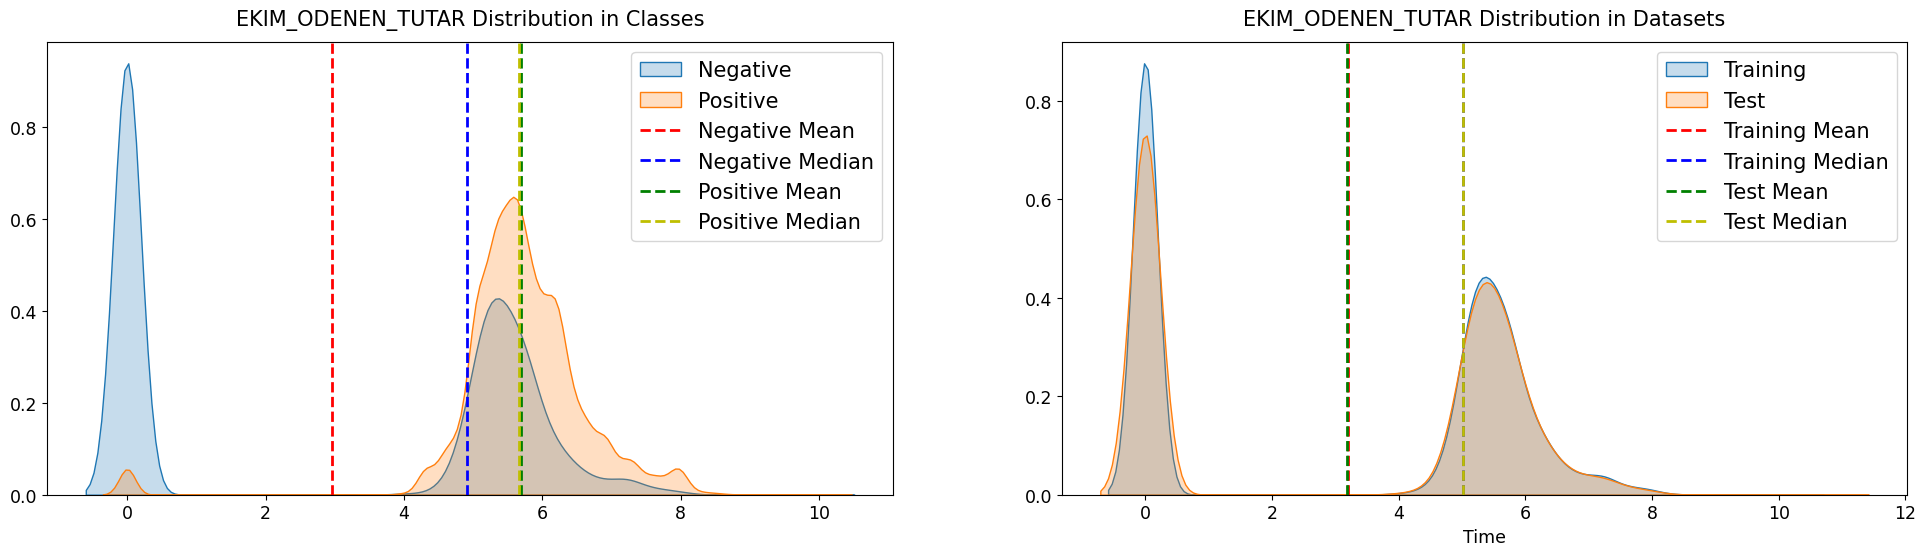

EKIM_VADE_TUTARI
----------------

Training
--------
Mean: 5.5550  -  Median: 5.4424  -  Std: 0.5677
Min: 2.8904  -  25%: 5.1985  -  50%: 5.4424  -  75%: 5.8319  -  Max: 11.4273
Skew: 1.2752  -  Kurtosis: 3.2848
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 5.5549  -  Median: 5.4424  -  Std: 0.5525
Min: 2.4849  -  25%: 5.1985  -  50%: 5.4424  -  75%: 5.8319  -  Max: 12.5975
Skew: 1.2844  -  Kurtosis: 3.5102
Missing Values: 0/243137 (0.0000%)


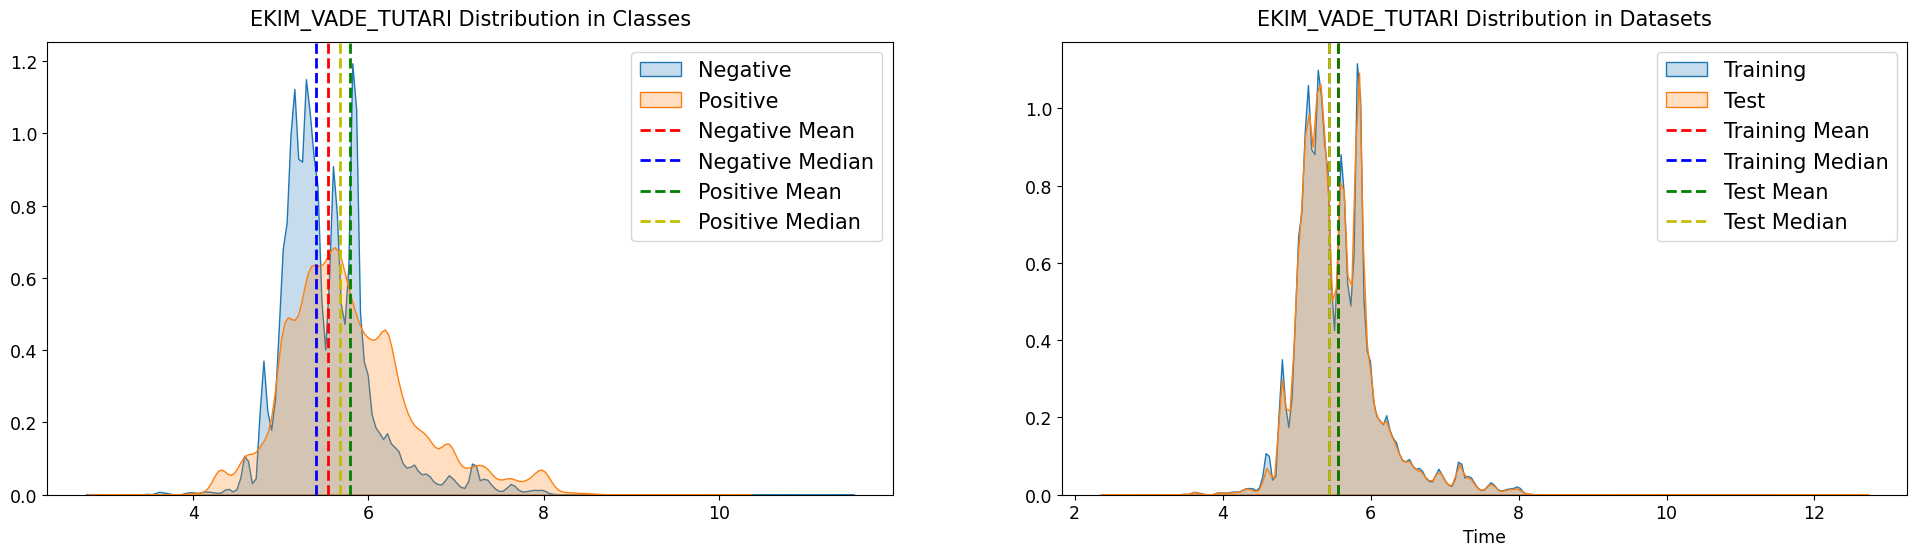

KASIM_ODENEN_TUTAR
------------------

Training
--------
Mean: 3.2034  -  Median: 5.0173  -  Std: 2.8316
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0173  -  75%: 5.6021  -  Max: 10.1267
Skew: -0.1839  -  Kurtosis: -1.8244
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 3.1819  -  Median: 5.0173  -  Std: 2.8261
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0173  -  75%: 5.6021  -  Max: 10.7144
Skew: -0.1773  -  Kurtosis: -1.8337
Missing Values: 0/243137 (0.0000%)


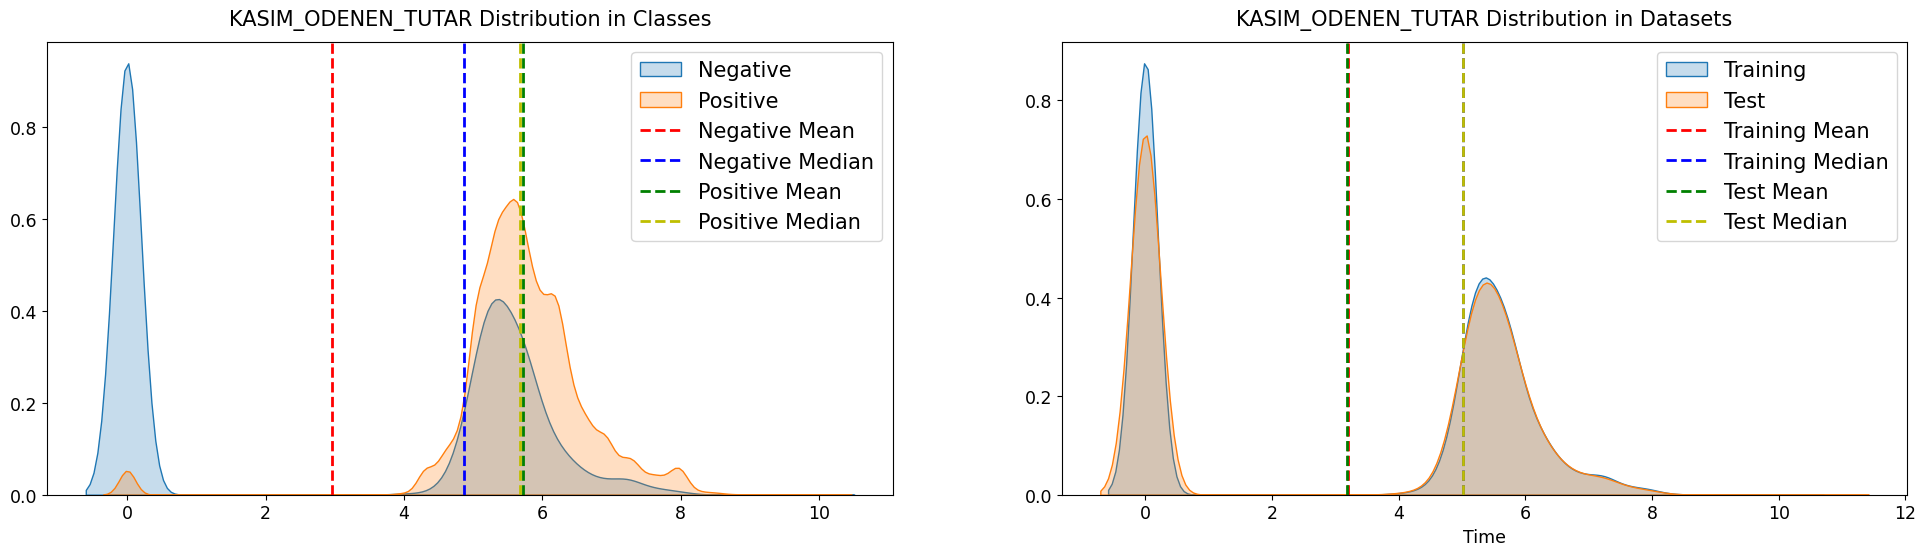

KASIM_VADE_TUTARI
-----------------

Training
--------
Mean: 5.5570  -  Median: 5.4424  -  Std: 0.5699
Min: 2.8904  -  25%: 5.1985  -  50%: 5.4424  -  75%: 5.8319  -  Max: 11.4273
Skew: 1.2763  -  Kurtosis: 3.2677
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 5.5567  -  Median: 5.4424  -  Std: 0.5542
Min: 2.4849  -  25%: 5.1985  -  50%: 5.4424  -  75%: 5.8319  -  Max: 12.5975
Skew: 1.2810  -  Kurtosis: 3.4482
Missing Values: 0/243137 (0.0000%)


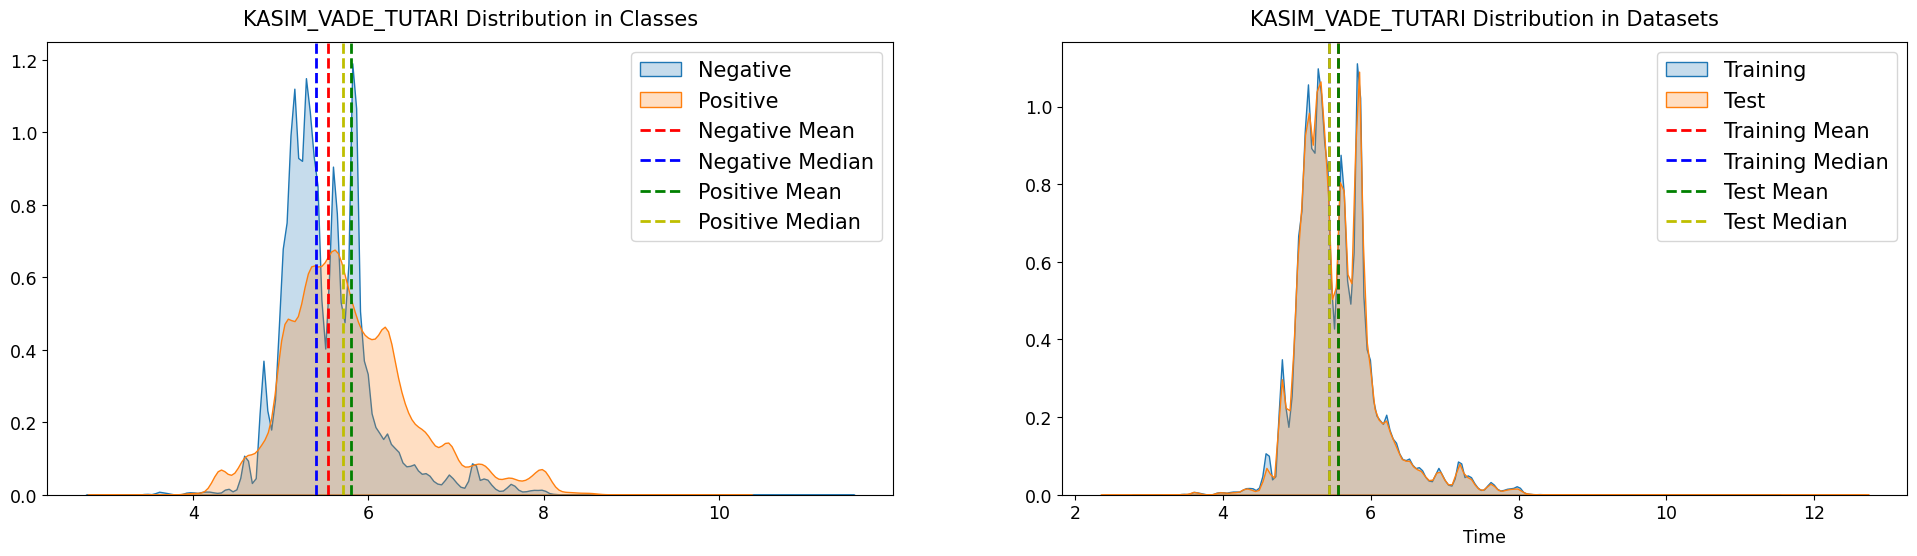

ARALIK_ODENEN_TUTAR
-------------------

Training
--------
Mean: 3.1962  -  Median: 5.0173  -  Std: 2.8337
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0173  -  75%: 5.6021  -  Max: 10.4721
Skew: -0.1780  -  Kurtosis: -1.8268
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 3.1743  -  Median: 5.0173  -  Std: 2.8281
Min: 0.0000  -  25%: 0.0000  -  50%: 5.0173  -  75%: 5.6021  -  Max: 10.7144
Skew: -0.1711  -  Kurtosis: -1.8362
Missing Values: 0/243137 (0.0000%)


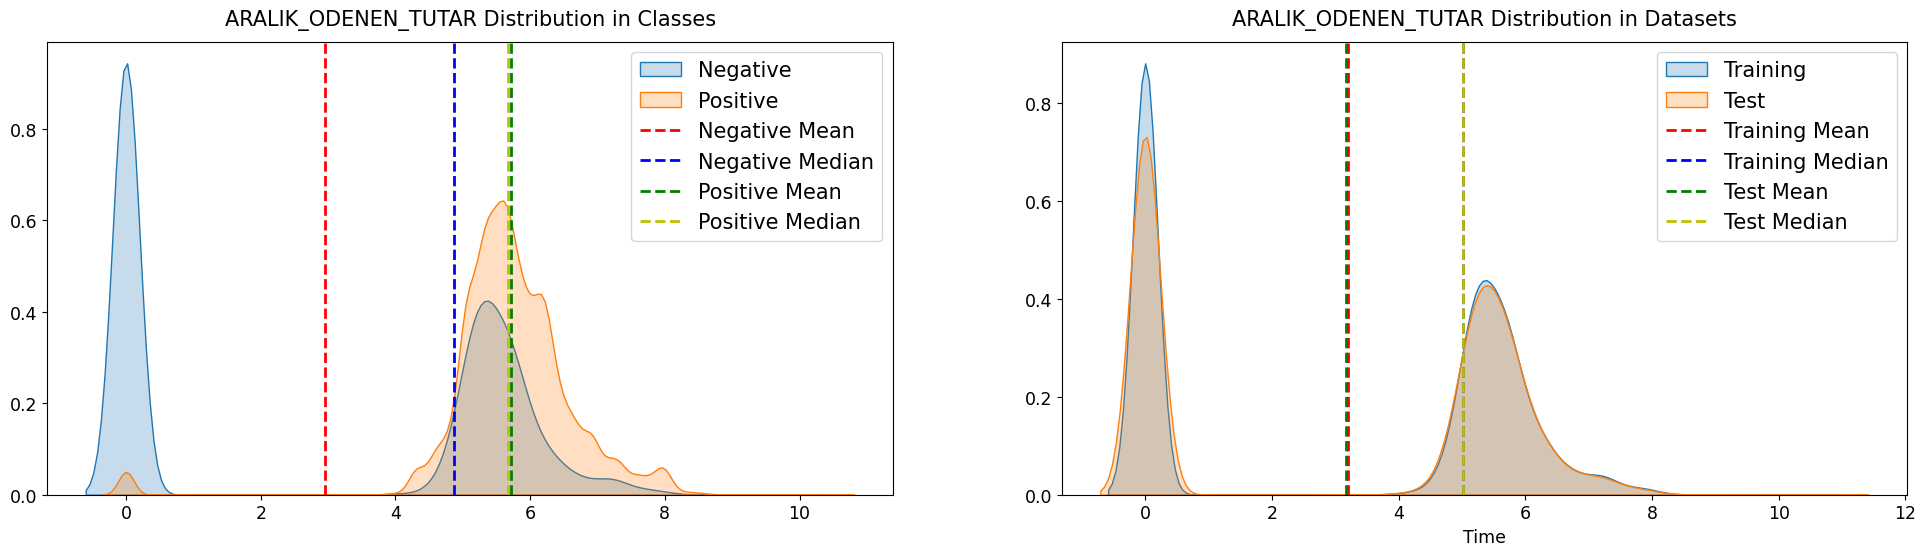

ARALIK_VADE_TUTARI
------------------

Training
--------
Mean: 5.5579  -  Median: 5.4424  -  Std: 0.5707
Min: 0.6931  -  25%: 5.1985  -  50%: 5.4424  -  75%: 5.8319  -  Max: 11.4273
Skew: 1.2735  -  Kurtosis: 3.2630
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 5.5576  -  Median: 5.4424  -  Std: 0.5549
Min: 2.4849  -  25%: 5.1985  -  50%: 5.4424  -  75%: 5.8319  -  Max: 12.5975
Skew: 1.2778  -  Kurtosis: 3.4218
Missing Values: 0/243137 (0.0000%)


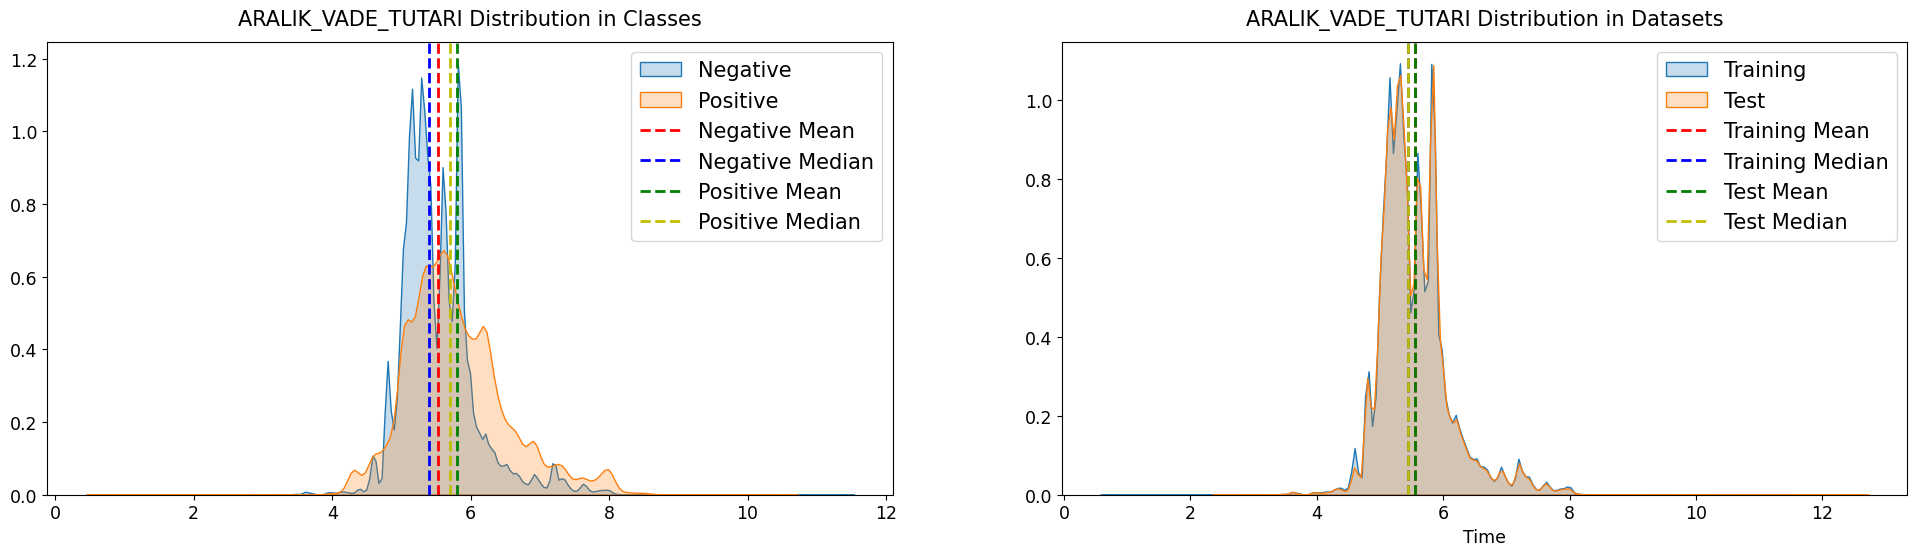

SENE_BASI_HESAP_DEGERI
----------------------

Training
--------
Mean: 8.2648  -  Median: 8.3846  -  Std: 1.6089
Min: 4.4018  -  25%: 6.8166  -  50%: 8.3846  -  75%: 9.4836  -  Max: 15.1465
Skew: 0.1125  -  Kurtosis: -0.9155
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 8.2345  -  Median: 8.3557  -  Std: 1.5918
Min: 0.6931  -  25%: 6.8018  -  50%: 8.3557  -  75%: 9.4355  -  Max: 14.0460
Skew: 0.1055  -  Kurtosis: -0.9296
Missing Values: 0/243137 (0.0000%)


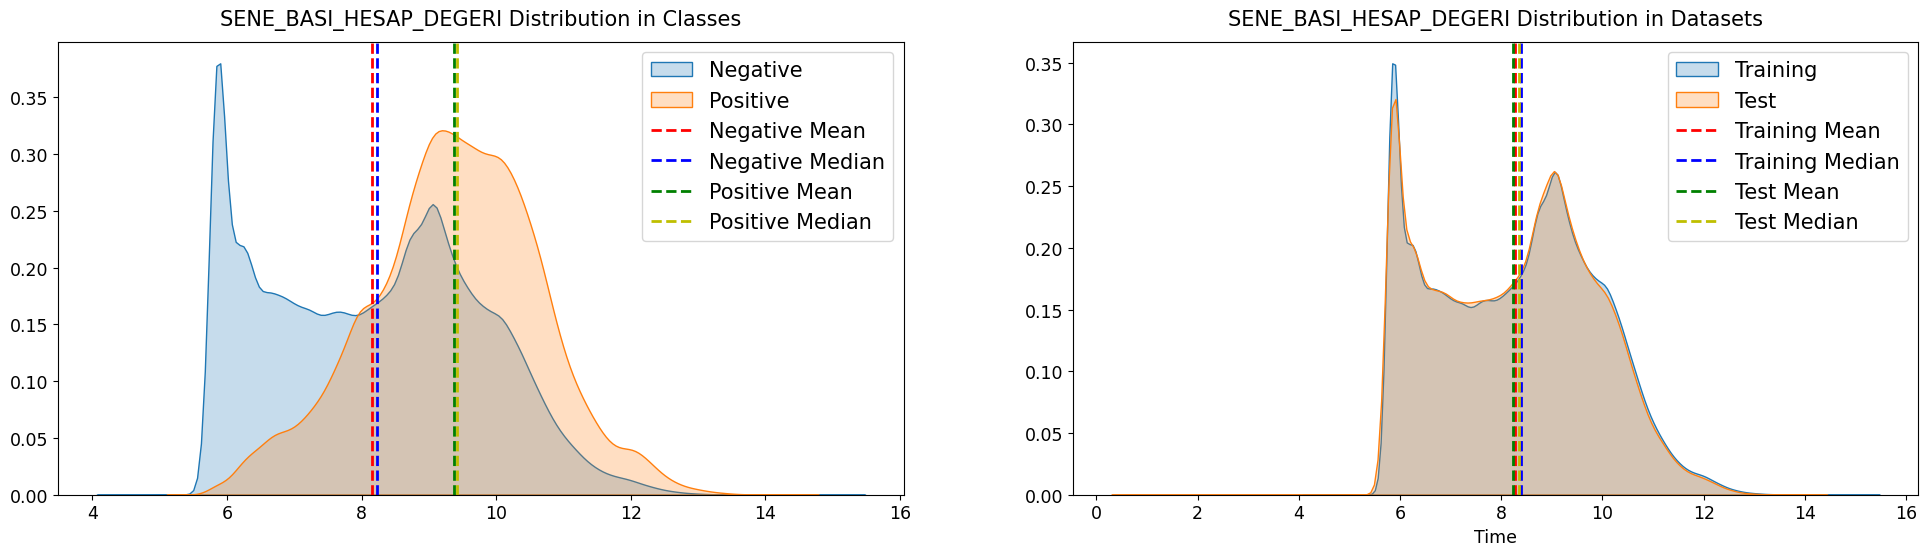

SENE_SONU_HESAP_DEGERI
----------------------

Training
--------
Mean: 8.3676  -  Median: 8.8815  -  Std: 2.0560
Min: 1.3737  -  25%: 6.8006  -  50%: 8.8815  -  75%: 9.8767  -  Max: 15.4263
Skew: -0.4313  -  Kurtosis: -0.7855
Missing Values: 0/634112 (0.0000%)

Test
----
Mean: 8.3347  -  Median: 8.8592  -  Std: 2.0438
Min: 0.6931  -  25%: 6.7714  -  50%: 8.8592  -  75%: 9.8307  -  Max: 14.3565
Skew: -0.4413  -  Kurtosis: -0.7944
Missing Values: 0/243137 (0.0000%)


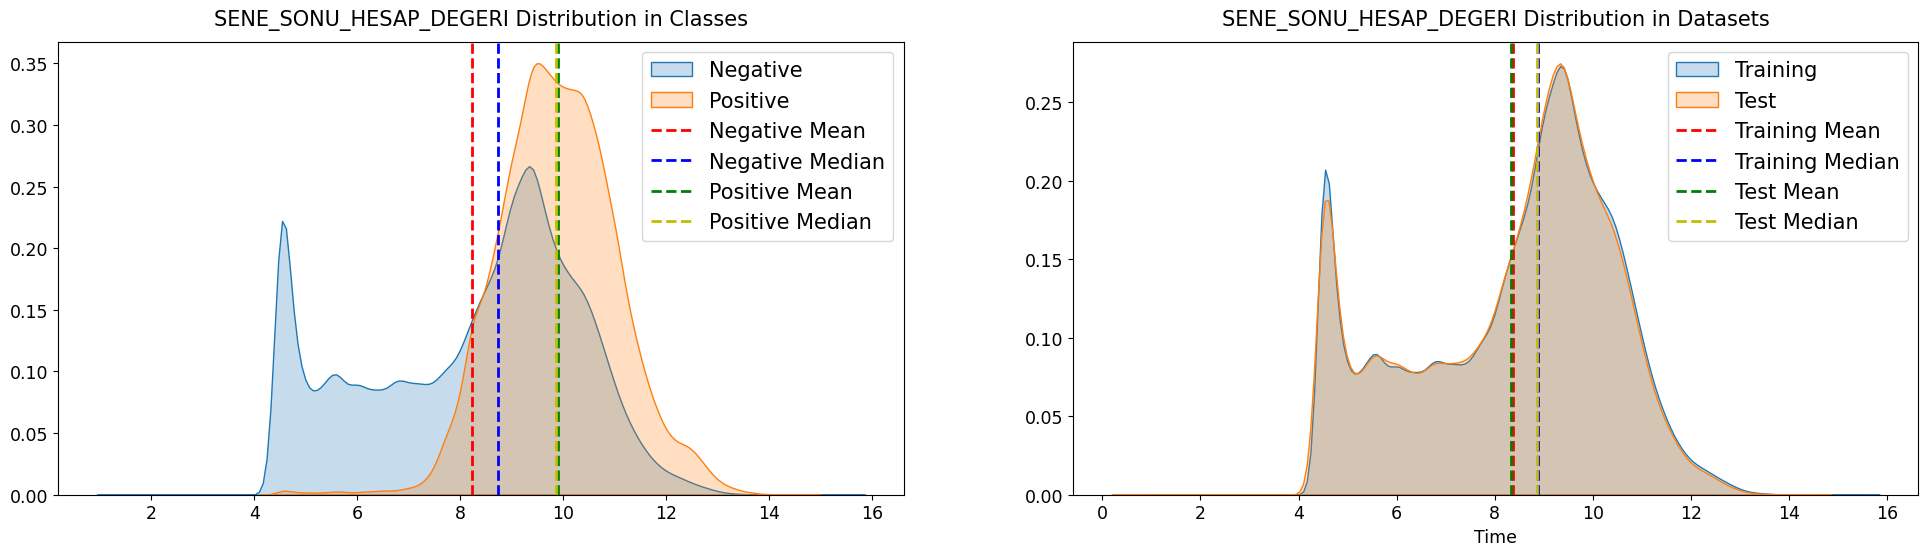

In [5]:
def visualize_continuous_feature(df_train, df_test, column):
    
    print(f'{column}\n{"-" * len(column)}')
    for dataset, df in zip(['Training', 'Test'], [df_train, df_test]):
        print(f'\n{dataset}\n{"-" * len(dataset)}')
        print(f'Mean: {df[column].mean():.4f}  -  Median: {df[column].median():.4f}  -  Std: {df[column].std():.4f}')
        print(f'Min: {df[column].min():.4f}  -  25%: {df[column].quantile(0.25):.4f}  -  50%: {df[column].quantile(0.5):.4f}  -  75%: {df[column].quantile(0.75):.4f}  -  Max: {df[column].max():.4f}')
        print(f'Skew: {df[column].skew():.4f}  -  Kurtosis: {df[column].kurtosis():.4f}')
        missing_count = df[df[column].isnull()].shape[0]
        total_count = df.shape[0]
        print(f'Missing Values: {missing_count}/{total_count} ({missing_count * 100 / total_count:.4f}%)')

    fig, axes = plt.subplots(ncols=2, figsize=(24, 6), dpi=100)
    
    sns.kdeplot(df_train.loc[df_train['ARTIS_DURUMU'] == 0, column], label='Negative', fill=True, ax=axes[0])
    sns.kdeplot(df_train.loc[df_train['ARTIS_DURUMU'] == 1, column], label='Positive', fill=True, ax=axes[0])
    axes[0].axvline(df_train.loc[df_train['ARTIS_DURUMU'] == 0, column].mean(), label='Negative Mean', color='r', linewidth=2, linestyle='--')
    axes[0].axvline(df_train.loc[df_train['ARTIS_DURUMU'] == 0, column].median(), label='Negative Median', color='b', linewidth=2, linestyle='--')
    axes[0].axvline(df_train.loc[df_train['ARTIS_DURUMU'] == 1, column].mean(), label='Positive Mean', color='g', linewidth=2, linestyle='--')
    axes[0].axvline(df_train.loc[df_train['ARTIS_DURUMU'] == 1, column].median(), label='Positive Median', color='y', linewidth=2, linestyle='--')
    axes[0].legend(prop={'size': 15})

    sns.kdeplot(df_train[column], label='Training', fill=True, ax=axes[1])
    sns.kdeplot(df_test[column], label='Test', fill=True, ax=axes[1])
    axes[1].axvline(df_train[column].mean(), label='Training Mean', color='r', linewidth=2, linestyle='--')
    axes[1].axvline(df_train[column].median(), label='Training Median', color='b', linewidth=2, linestyle='--')
    axes[1].axvline(df_test[column].mean(), label='Test Mean', color='g', linewidth=2, linestyle='--')
    axes[1].axvline(df_test[column].median(), label='Test Median', color='y', linewidth=2, linestyle='--')
    axes[1].legend(prop={'size': 15})
    
    for i in range(2):
        axes[i].tick_params(axis='x', labelsize=12.5)
        axes[i].tick_params(axis='y', labelsize=12.5)
        axes[i].set_ylabel('')
    axes[0].set_xlabel('')
    axes[1].set_xlabel('Time', fontsize=12.5)
    axes[0].set_title(f'{column} Distribution in Classes', fontsize=15, pad=12)
    axes[1].set_title(f'{column} Distribution in Datasets', fontsize=15, pad=12)
    
    plt.show()


for continuous_feature in positive_continous_features + positive_and_negative_continuous_features:
    visualize_continuous_feature(df_train, df_test, continuous_feature)

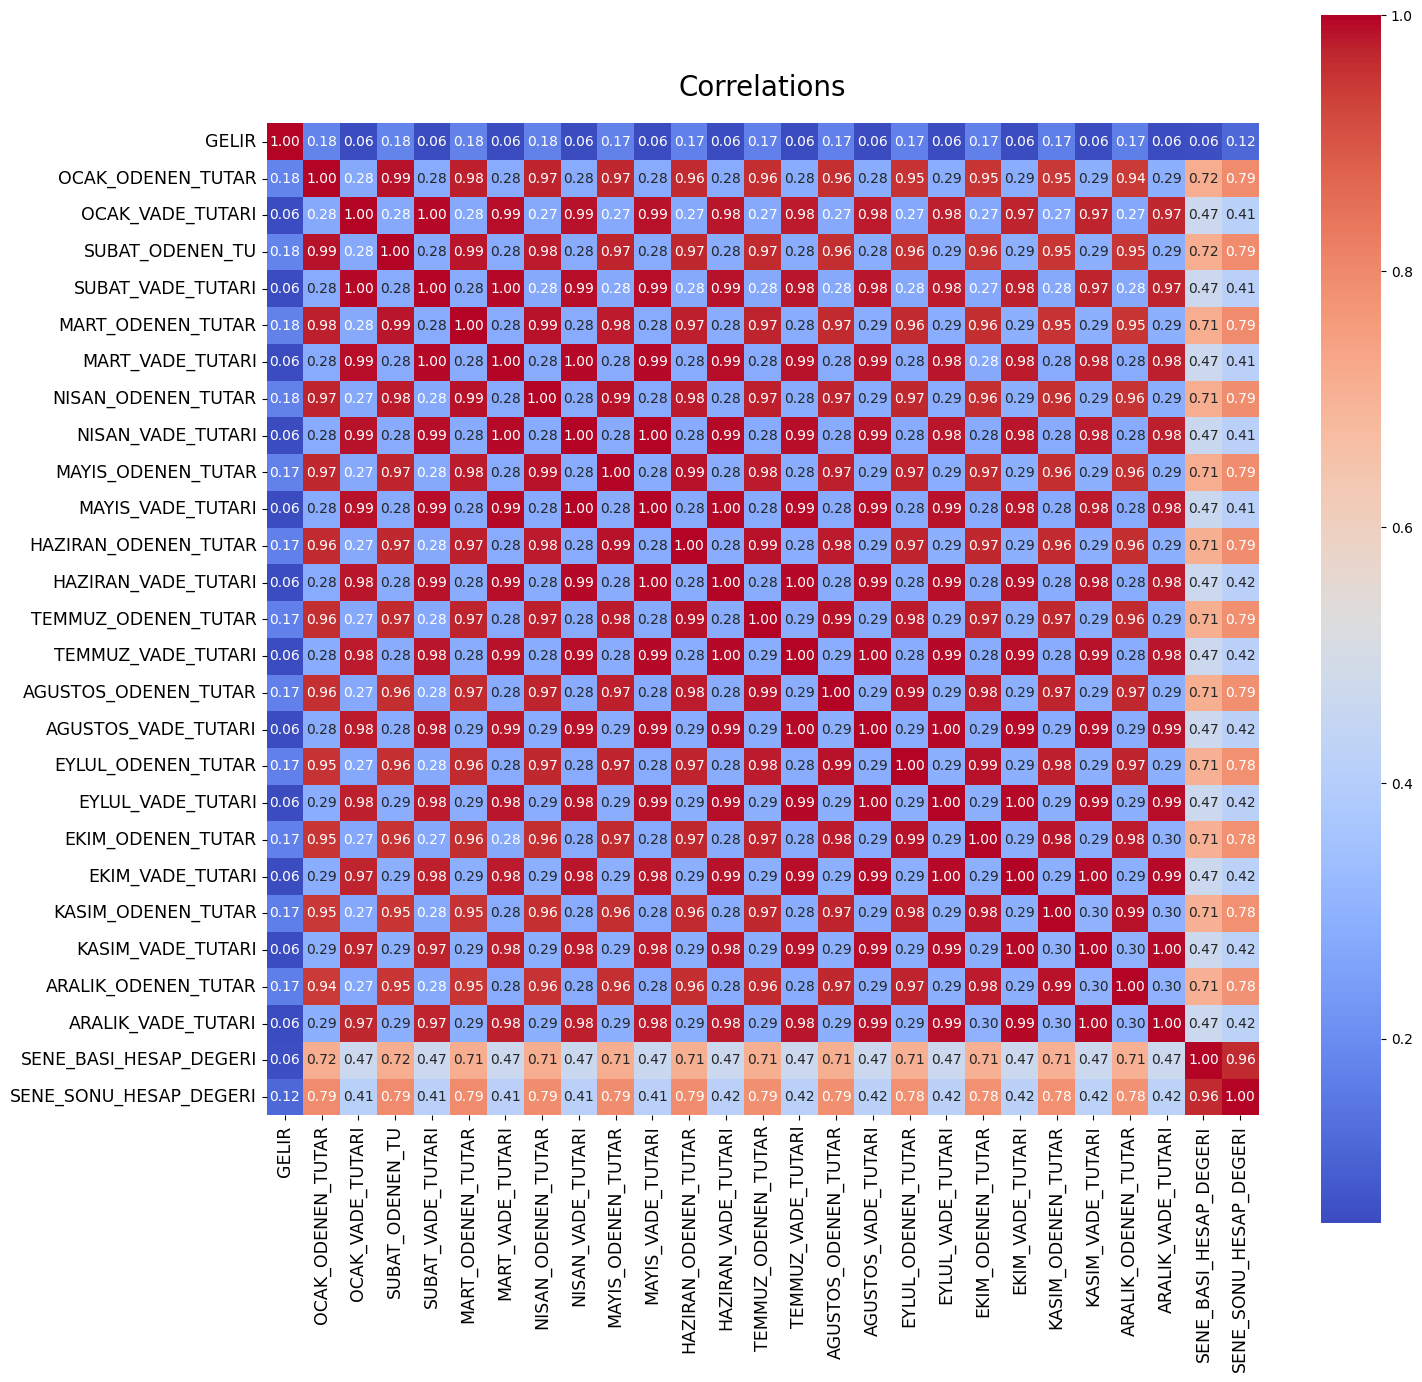

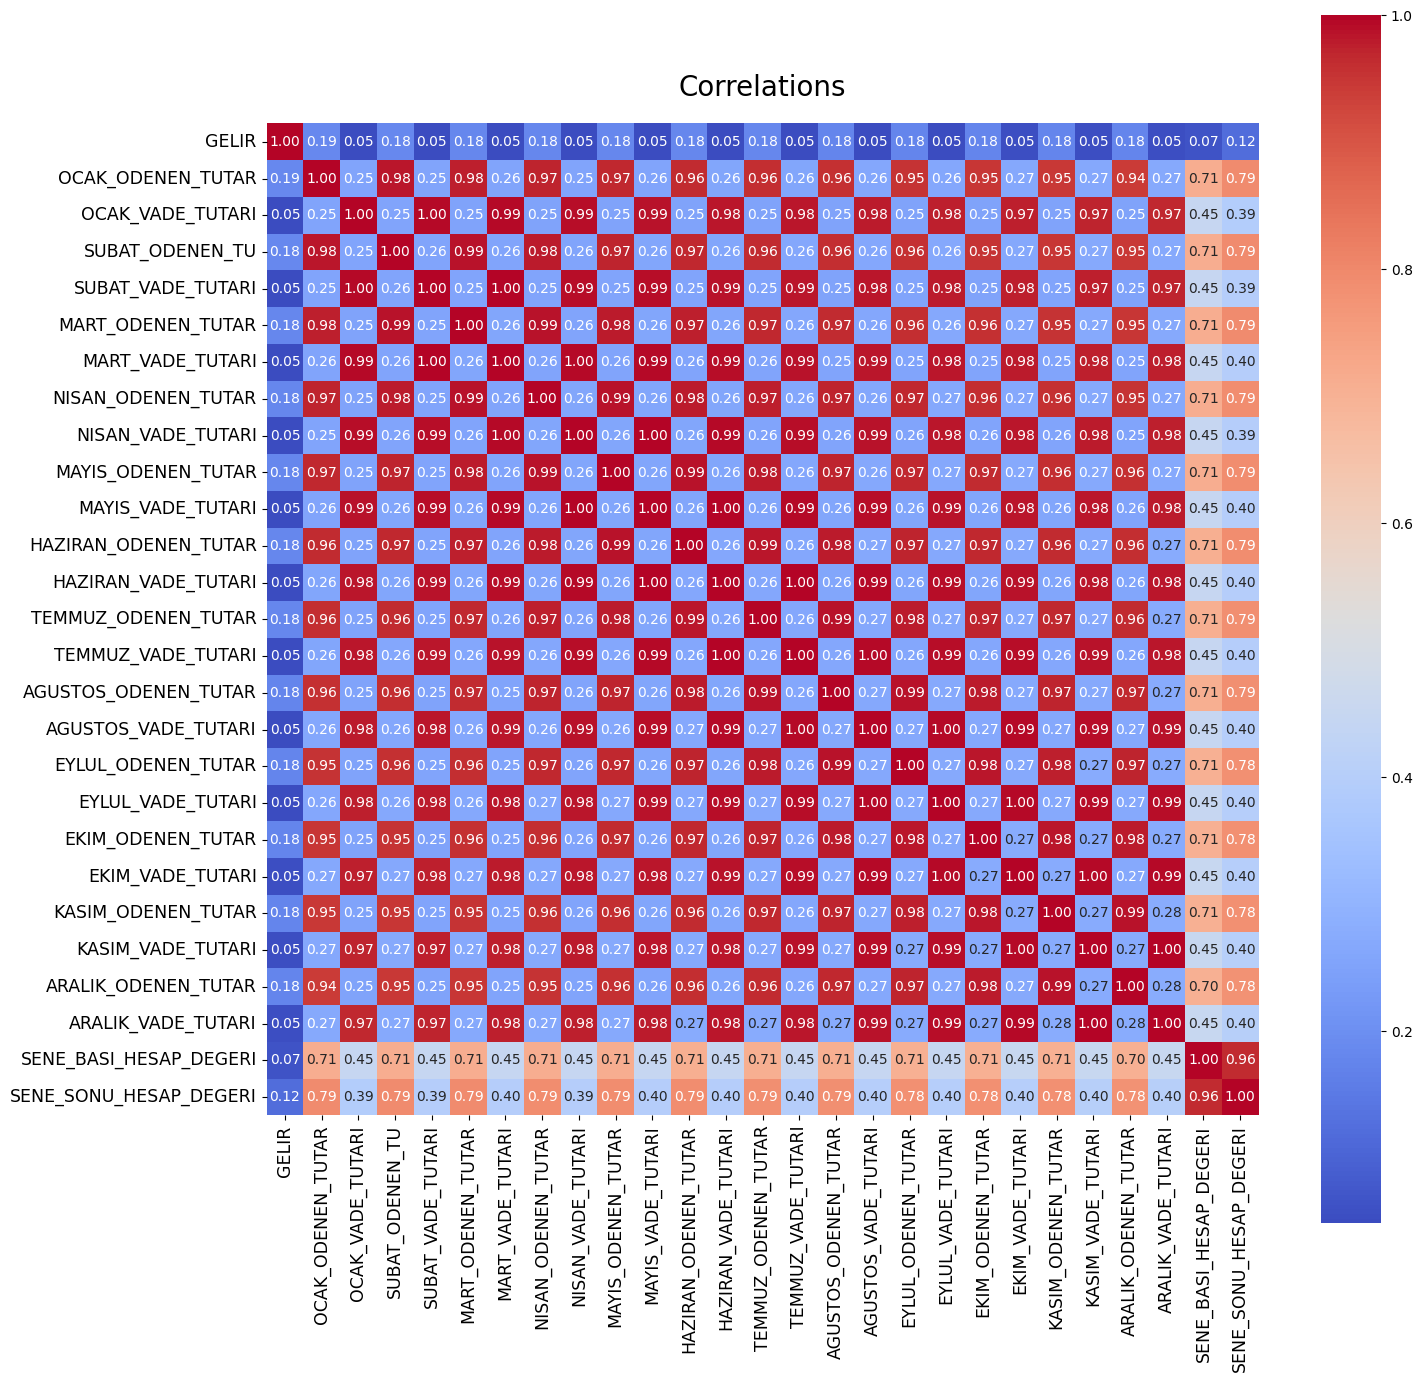

In [6]:
def visualize_correlations(df, features):

    fig = plt.figure(figsize=(16, 16), dpi=100)
    sns.heatmap(
        df[features].corr(),
        annot=True,
        square=True,
        cmap='coolwarm',
        annot_kws={'size': 10},
        fmt='.2f'
    )

    plt.tick_params(axis='x', labelsize=12.5, rotation=90)
    plt.tick_params(axis='y', labelsize=12.5, rotation=0)
    plt.title('Correlations', size=20, pad=20)

    plt.show()


visualize_correlations(df_train, (positive_continous_features + positive_and_negative_continuous_features))
visualize_correlations(df_test, (positive_continous_features + positive_and_negative_continuous_features))